In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os 

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [15]:
output_dir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_plots/deepSC_v4_wps/"

In [2]:
from keras.models import load_model
model = load_model("../models/v4_newwindow/model3_newwindow_big.hd5")
scaler = pickle.load(open("../models/v4_newwindow/scaler_model2.pkl", "rb"))

#model_base = load_model("../models/v1_baseline/model12_balanced_100_50.hd5")
#scaler_base = pickle.load(open("../models/v1_baseline/scaler_gamma_electrons.pkl", "rb"))

#model_new = load_model("../models/v3_newscore/model1_newscore_100_80_50.hd5")
#scaler_new = pickle.load(open("../models/v3_newscore/scaler_model1.pkl", "rb"))

Using TensorFlow backend.
W0422 14:17:08.171528 139990563710784 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0422 14:17:08.219568 139990563710784 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0422 14:17:08.259456 139990563710784 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0422 14:17:08.261453 139990563710784 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch

In [5]:
scaler.scale_

array([1.96599144e+00, 1.80202980e+00, 7.90502791e-01, 1.13024322e+02,
       2.84211205e+01, 1.48337083e-01, 3.51219513e-01, 5.94872791e+00,
       2.55081062e+00, 2.10498421e-01, 1.62976718e-02, 3.48374888e-04,
       1.75901776e-02, 4.05079143e-01, 5.72003083e+00, 6.72692211e+00,
       1.88644832e-02, 4.32051323e-04, 2.04529410e-02, 4.11702088e-01,
       3.31624726e+00])

## Load data
Seed is included

In [4]:
datas_ele = []

for i in range(16, 25):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v5_mustache/validation/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    datas_ele.append( d[(d.is_calo_matched == True)] )

    
data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

datas_gamma = []
for i in range(17, 28):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/gammas/numpy_v5_mustache/validation/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    datas_gamma.append(d[ (d.is_calo_matched == True)])
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data_val = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data_val = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)

file not found:  /eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v5_mustache/validation/clusters_data_20.pkl
N events ele:  2923913
N events gamma:  3888147


In [5]:
print(f"N samples ele {data_ele.shape}")
print(f"N samples gamma {data_gamma.shape}")

N samples ele (2923913, 34)
N samples gamma (3888147, 34)


# Evaluation

In [6]:
cols = ["seed_eta", "seed_phi", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9d", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi","seed_swissCross","seed_nxtals",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi","cl_swissCross", "cl_nxtals"]

In [7]:
#data_val["y_baseline"] = model_base.predict(scaler_base.transform(data_val[cols_base].values), batch_size=2048)
data_val["y"] = model.predict(scaler.transform(data_val[cols].values), batch_size=2048)
#data_ele["y_new"] = model_new.predict(scaler_new.transform(data_ele[cols_shower].values), batch_size=2048)

In [8]:
data_out = data_val[data_val.in_scluster== False]
data_in = data_val[data_val.in_scluster == True]


### Mustache efficiency

In [18]:
TP_must = data_val[(data_val.in_scluster==True) & ( data_val.in_mustache==True) ]
TN_must = data_val[(data_val.in_scluster==False) & ( data_val.in_mustache==False) ]
FP_must = data_val[(data_val.in_scluster==False) & ( data_val.in_mustache==True) ]
FN_must = data_val[(data_val.in_scluster==True) & ( data_val.in_mustache==False) ]
T_must = data_val[data_val.in_scluster==True]
F_must = data_val[data_val.in_scluster==False]

In [12]:
print(f"Background contamination {len(FP_must)/len(F_must)}")
print(f"Signal efficiency {len(TP_must)/len(T_must)}")

Background contamination 0.07690516775454205
Signal efficiency 0.8326263144225198


## ROCs by energy

In [15]:
data_val.columns

Index(['cluster_deta', 'cluster_dphi', 'cluster_iz', 'en_cluster', 'en_seed',
       'en_true', 'f5_r9', 'f5_sigmaIetaIeta', 'f5_sigmaIetaIphi',
       'f5_sigmaIphiIphi', 'in_mustache', 'in_scluster', 'index', 'is_calo',
       'is_seed', 'max_dr_cluster', 'max_en_cluster', 'nclusters', 'nxtals',
       'seed_eta', 'seed_iz', 'seed_phi', 'swissCross', 'window_index',
       'particle', 'y_baseline', 'y_shower'],
      dtype='object')

## Barrell

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve
y_test = np.array(data_val.in_scluster, dtype=int)
pred_shower = data_val["y"].values

energies = [0, 10,20,30,40,50,75,100]
ebins = []
for ie in range(len(energies)-1):
    ebin = (energies[ie], energies[ie+1])
    ebins.append(ebin)
    
rocs_en = {}
rocs_mustache = {}
    
for ebin in ebins:
    print(ebin)
    mask = ( (data_val.en_seed / np.cosh(data_val.seed_eta))> ebin[0])&( (data_val.en_seed / np.cosh(data_val.seed_eta))  < ebin[1] )& (abs(data_val.seed_eta) < 1.5 )
    y_test = np.array(data_val[mask].in_scluster)
    print(len(y_test))
    pred_shower = data_val[mask]["y"].values
    auc_shower = roc_auc_score(y_test,pred_shower)
    fp_shower, tp_shower, th_shower = roc_curve(y_test, pred_shower)
    rocs_en[ebin] = (auc_shower,fp_shower, tp_shower, th_shower )
    
    FP_must = data_val[mask & (data_val.in_scluster==False) & ( data_val.in_mustache==True) ]
    TP_must = data_val[mask & (data_val.in_scluster==True) & ( data_val.in_mustache==True) ]
    T_must = data_val[mask& data_val.in_scluster==True]
    F_must = data_val[mask & data_val.in_scluster==False]
    
    rocs_mustache[ebin] = (len(TP_must)/ len(T_must), len(FP_must)/len(F_must))

(0, 10)
489611


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,7), dpi=100)

for ebin, (auc_shower,fp_shower, tp_shower, th_shower ) in rocs_en.items():
    ax1.plot(tp_shower, fp_shower, label=f"ROC {ebin[0]} < E < {ebin[1]} GeV")
    


for ebin, (sig_eff_must, bkg_cont_must) in rocs_mustache.items():
    ax1.scatter(sig_eff_must, bkg_cont_must, marker="^", s=15**2, label=f"Mustache {ebin[0]} < E < {ebin[1]} GeV")

    
ax1.grid("y")
ax1.set_xlabel("Signal efficiency (single cluster)", fontsize=16)
ax1.set_ylabel("Background contamination", fontsize=17)

ax1.set_ylim(0.001, 1)
ax1.set_xlim(0.7, 1.01)
ax1.set_yscale("log")
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")
#ax1.tick_params("x",labelsize="large")

    

ax1.set_title("SuperCluster algo ROC curves", fontsize=20)



#ax2.text(x = 0.048, y = 1.01, s=f"AUC={auc:.3f}", fontsize="large")
ax1.legend(loc=(0, 0.6), fontsize="large", ncol=2)

fig.tight_layout()

## Endcap

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
y_test = np.array(data_val.in_scluster, dtype=int)
pred_shower = data_val["y_shower"].values

energies = [0, 10,20,30,40,50,75,100]
ebins = []
for ie in range(len(energies)-1):
    ebin = (energies[ie], energies[ie+1])
    ebins.append(ebin)
    
rocs_en = {}
rocs_mustache = {}
    
for ebin in ebins:
    print(ebin)
    mask = ( (data_val.en_seed / np.cosh(data_val.seed_eta))> ebin[0])&( (data_val.en_seed / np.cosh(data_val.seed_eta))  < ebin[1] )& (abs(data_val.seed_eta) > 1.5 )
    y_test = np.array(data_val[mask].in_scluster)
    print(len(y_test))
    pred_shower = data_val[mask]["y_shower"].values
    auc_shower = roc_auc_score(y_test,pred_shower)
    fp_shower, tp_shower, th_shower = roc_curve(y_test, pred_shower)
    rocs_en[ebin] = (auc_shower,fp_shower, tp_shower, th_shower )
    
    FP_must = data_val[mask & (data_val.in_scluster==False) & ( data_val.in_mustache==True) ]
    TP_must = data_val[mask & (data_val.in_scluster==True) & ( data_val.in_mustache==True) ]
    T_must = data_val[mask& data_val.in_scluster==True]
    F_must = data_val[mask & data_val.in_scluster==False]
    
    rocs_mustache[ebin] = (len(TP_must)/ len(T_must), len(FP_must)/len(F_must))

(0, 10)
115067
(10, 20)
105871
(20, 30)
97544
(30, 40)
94912
(40, 50)
94958
(50, 75)
231272
(75, 100)
167546


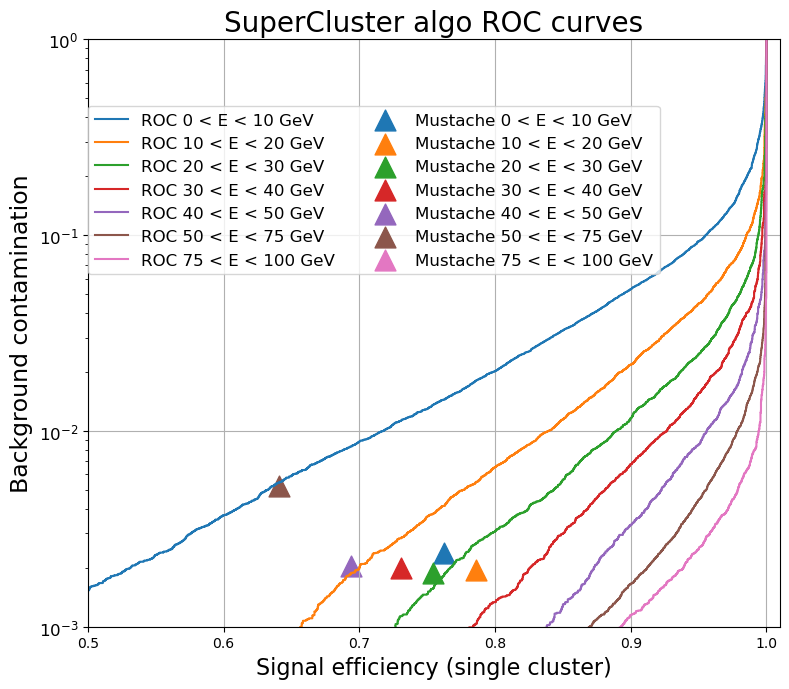

In [16]:
fig, ax1 = plt.subplots(figsize=(8,7), dpi=100)

for ebin, (auc_shower,fp_shower, tp_shower, th_shower ) in rocs_en.items():
    ax1.plot(tp_shower, fp_shower, label=f"ROC {ebin[0]} < E < {ebin[1]} GeV")
    


for ebin, (sig_eff_must, bkg_cont_must) in rocs_mustache.items():
    ax1.scatter(sig_eff_must, bkg_cont_must, marker="^", s=15**2, label=f"Mustache {ebin[0]} < E < {ebin[1]} GeV")

    
ax1.grid("y")
ax1.set_xlabel("Signal efficiency (single cluster)", fontsize=16)
ax1.set_ylabel("Background contamination", fontsize=17)

ax1.set_ylim(0.001, 1)
ax1.set_xlim(0.5, 1.01)
ax1.set_yscale("log")
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")
#ax1.tick_params("x",labelsize="large")

    

ax1.set_title("SuperCluster algo ROC curves", fontsize=20)



#ax2.text(x = 0.048, y = 1.01, s=f"AUC={auc:.3f}", fontsize="large")
ax1.legend(loc=(0, 0.6), fontsize="large", ncol=2)

fig.tight_layout()

In [17]:
shower_results = [th_shower, fp_shower, tp_shower]
base_results = [th_base, fp_base, tp_base]

pickle.dump(shower_results, open("shower_roc.pk", "wb"))
pickle.dump(base_results, open("base_roc.pk", "wb"))

### Thresholds values

In [14]:
th, fp,tp = th_shower, fp_shower,tp_shower
print("threshold for 2% bkg", th[fp>= 0.02][0], "sig eff. ", tp[fp>= 0.02][0])
print("threshold for 1% bkg", th[fp>= 0.01][0], "sig eff. ", tp[fp>= 0.01][0])
print("threshold for 0.5% bkg", th[fp>= 0.005][0], "sig eff. ", tp[fp>= 0.005][0])

threshold for 2% bkg 0.55694216 sig eff.  0.9597631875120703
threshold for 1% bkg 0.81116545 sig eff.  0.9242812714353261
threshold for 0.5% bkg 0.9242587 sig eff.  0.8828723836415581


In [54]:
print(f"1% bkg contamination threshold: {th_base[(fp_base<=0.0100000) & (fp_base >=0.00999)][0]:.5f} baseline")
print(f"1% bkg contamination threshold: {th_shower[(fp_shower<=0.0100000) & (fp_shower >=0.00999)][0]:.5f} shower")

1% bkg contamination threshold: 0.87876 baseline
1% bkg contamination threshold: 0.88023 shower


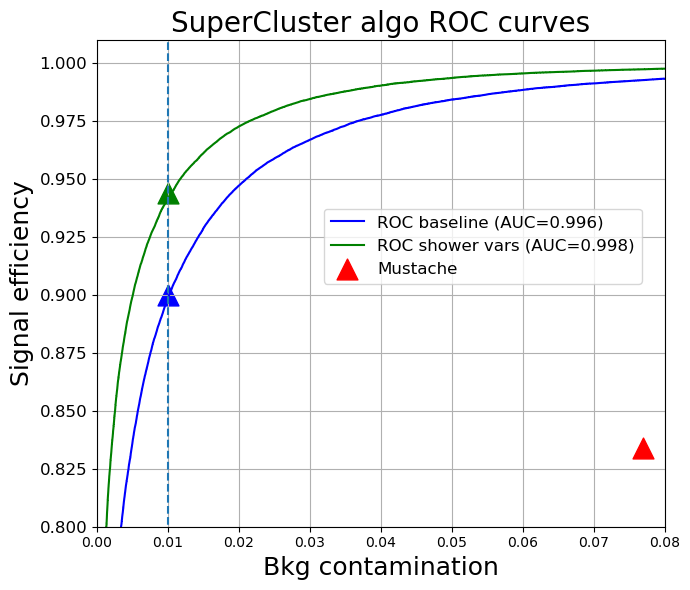

In [15]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

ax1.plot(fp_base, tp_base, label=f"ROC baseline (AUC={auc_base:.3f})", color="blue")
ax1.plot(fp_shower, tp_shower, label=f"ROC shower vars (AUC={auc_shower:.3f})", color="green")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

ax1.plot([0.01, 0.01], [0, 2], "--")

ax1.scatter(0.077, 0.834, marker="^", c="red", s=15**2, label="Mustache")
ax1.scatter(0.01, 0.9, marker="^", c="blue", s=15**2)
ax1.scatter(0.01, 0.944, marker="^", c="green", s=15**2)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.set_title("SuperCluster algo ROC curves", fontsize=20)

ax1.set_ylim(0.80, 1.01)
ax1.set_xlim(0, 0.08)
ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()

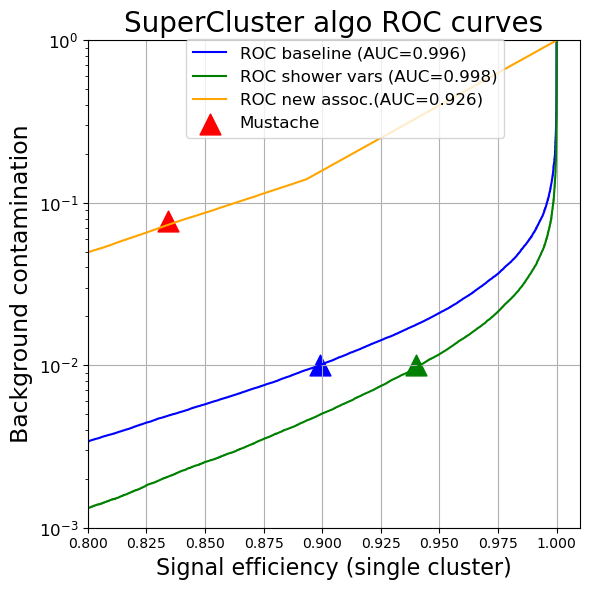

In [18]:
fig, ax1 = plt.subplots(figsize=(6,6), dpi=100)

ax1.plot(tp_base, fp_base,label=f"ROC baseline (AUC={auc_base:.3f})", color="blue")
ax1.plot(tp_shower, fp_shower, label=f"ROC shower vars (AUC={auc_shower:.3f})", color="green")
ax1.plot(tp_new, fp_new, label=f"ROC new assoc.(AUC={auc_new:.3f})", color="orange")

ax1.grid("y")
ax1.set_xlabel("Signal efficiency (single cluster)", fontsize=16)
ax1.set_ylabel("Background contamination", fontsize=17)
ax1.set_ylim(0.001, 1)
ax1.set_xlim(0.8, 1.01)
ax1.set_yscale("log")
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")
#ax1.tick_params("x",labelsize="large")

ax1.scatter(0.834, 0.077, marker="^", c="red", s=15**2, label="Mustache")
ax1.scatter(0.899, 0.01, marker="^", c="blue", s=15**2)
ax1.scatter(0.94, 0.01, marker="^", c="green", s=15**2)

ax1.set_title("SuperCluster algo ROC curves", fontsize=20)



#ax2.text(x = 0.048, y = 1.01, s=f"AUC={auc:.3f}", fontsize="large")
ax1.legend(loc=(0.2, 0.8), fontsize="large")

fig.tight_layout()

### Score histos

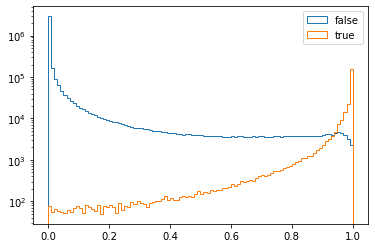

In [41]:
plt.hist(data_out["y"], bins=100, label="false", histtype="step")
plt.hist(data_in["y"], bins=100, label="true", histtype="step")
plt.yscale("log")
plt.legend()

## Energy resolution plot

In [39]:
data_val.head()

,cluster_deta,cluster_dphi,cluster_iz,en_cluster,en_seed,en_true,f5_r9,f5_sigmaIetaIeta,f5_sigmaIetaIphi,f5_sigmaIphiIphi,...,nclusters,nxtals,seed_eta,seed_iz,seed_phi,swissCross,window_index,particle,y_baseline,y_shower
0,-0.003412,0.071692,-1,8.055827,127.678032,155.121643,8.249754,0.022025,-0.000575,0.057203,...,4.0,7,-1.560894,-1,1.940542,-0.251004,gxhlzpep,gamma,0.999968,1.000000
1,0.023874,-0.130254,-1,7.653200,127.678032,155.121643,0.731156,0.049996,0.000121,0.055697,...,4.0,9,-1.560894,-1,1.940542,-0.454647,gxhlzpep,gamma,0.999151,0.999954
2,-0.097533,-0.405969,1,10.222507,385.151154,399.208160,1.598303,0.044627,-0.000749,0.061672,...,1.0,1,2.738315,1,1.129610,1.000000,yqdmpyxl,gamma,0.013523,0.001871
3,0.109550,-0.318967,1,6.491919,385.151154,399.208160,4.003832,0.046322,0.000197,0.069763,...,1.0,1,2.738315,1,1.129610,1.000000,yqdmpyxl,gamma,0.074700,0.027465
4,0.150268,-0.084702,0,1.987930,83.477028,83.973732,1.273465,0.016544,0.000061,0.017269,...,1.0,1,0.873116,0,1.426054,1.000000,dkpmwoqh,gamma,0.001944,0.012146


In [18]:
thresholds = [0.4,0.7,0.8,0.85, 0.873,0.9,0.95,0.99]

results = {}

for t in thresholds:

    g = data_val[(data_val.y >  t) | (data_val.is_seed==True)].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum', 
                          "en_true": "first", 
                          "en_seed": "first",
                          "seed_eta": "first",
                          "seed_phi": "first"})
    g["ratio"] = g["en_cluster"] / g["en_true"]
    
    results[t] = g

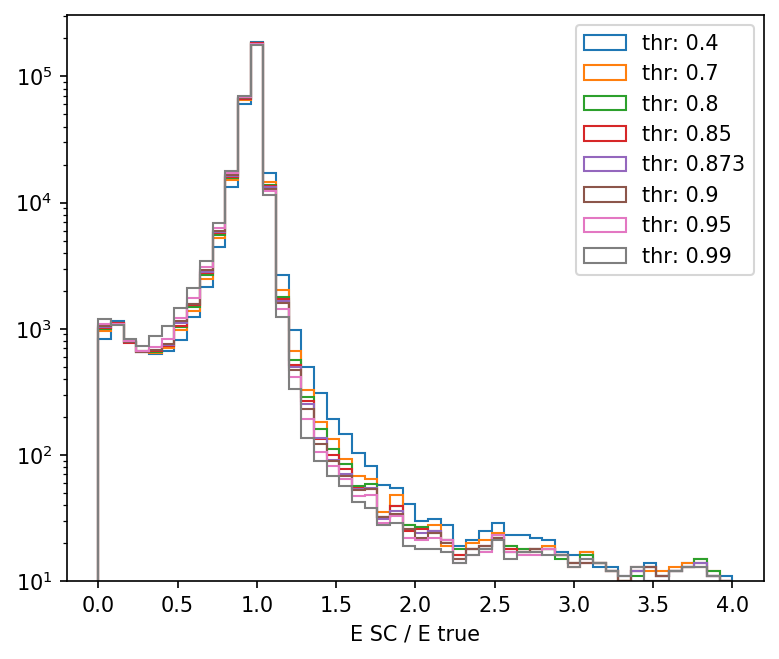

In [19]:
fig, _ = plt.subplots(figsize=(6,5), dpi=150)
for t , g in results.items():
    plt.hist(g.ratio, range=(0,4), bins=50,  histtype="step", label=f"thr: {t}", log=True, bottom=10)
plt.xlabel("E SC / E true")
plt.legend()

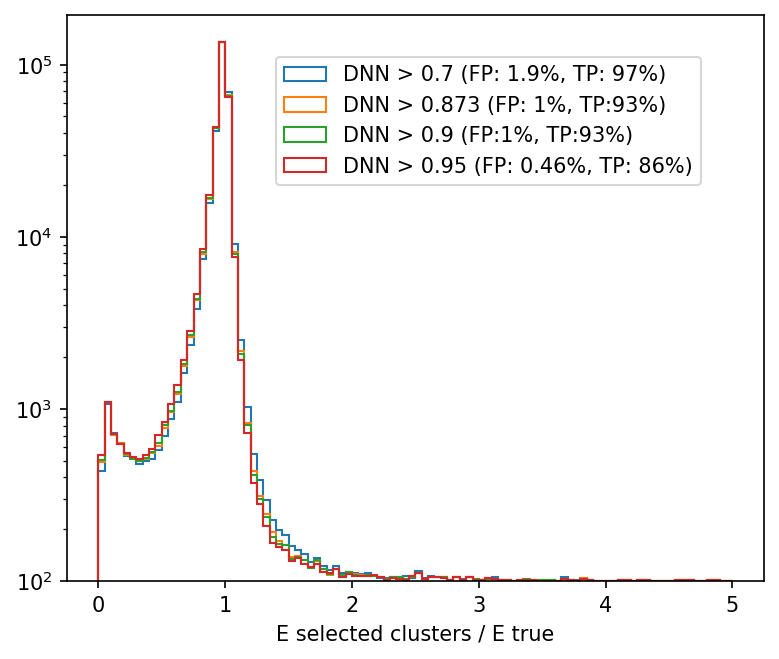

In [20]:
fig, ax = plt.subplots(figsize=(6,5), dpi=150)

info =    {
           0.7: "FP: 1.9%, TP: 97%", 
           0.873: "FP: 1%, TP:93%",
           0.9: "FP:1%, TP:93%",
           0.95: "FP: 0.46%, TP: 86%"}

for t , g in results.items():
    if t  not in [0.7, 0.873, 0.9, 0.95]: continue
    ax.hist(g.ratio, range=(0,5), bins=100,  histtype="step", label=f"DNN > {t} ({info[t]})", log=True, bottom=1e2)
ax.set_xlabel("E selected clusters / E true")
ax.legend(loc=(0.3, 0.7))

# Scale and resolution by DNN threshold and ET seed
## Barrel

### By Et seed

In [12]:
eta_range = [0,1.479]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dnn_thres =  np.linspace(0.1 ,1, 40)[:-1]



results= []

def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    return pd.Series(  
        { 
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (abs(ratio_right-ratio_mean) + abs(ratio_left-ratio_mean))/2, 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std()
        })

for thr in dnn_thres:
    #print("DNN threshold: ", thr)
    g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)< eta_range[1]) &
                 ( (data_val.y >  thr) | (data_val.is_seed==True) ) ].groupby("window_index", sort=False).agg(
                            { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_seed": "first",
                              })
    g.columns = ["en_cluster", "en_true", "et_seed"]
    #print(g)
    g["EoEtrue"] = g["en_cluster"] / g["en_true"]
    g["en_bin"] = pd.cut(g["et_seed"], ens, labels=list(range(len(ens)-1)))
    
    scanres = g.groupby("en_bin").apply(bin_analysis)
    scanres["dnn_thre"] = thr
    results.append(scanres)

result_eb = pd.concat(results)
#result.columns = ["_".join(col_name).rstrip('_') for col_name in result.columns.to_flat_index()]

# index by en_bin and DNN threshold
result_eb.reset_index(level=0, inplace=True)

g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)<eta_range[1]) &
             ( (data_val.in_mustache==True) | (data_val.is_seed==True)) ].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_seed": "first",
                              })
#print(g)
g["EoEtrue"] = g["en_cluster"] / g["en_true"]
g["en_bin"] = pd.cut(g["et_seed"], ens, labels=list(range(len(ens)-1)))

result_eb_must = g.groupby("en_bin").apply(bin_analysis)

result_eb_must.reset_index(level=0, inplace=True)

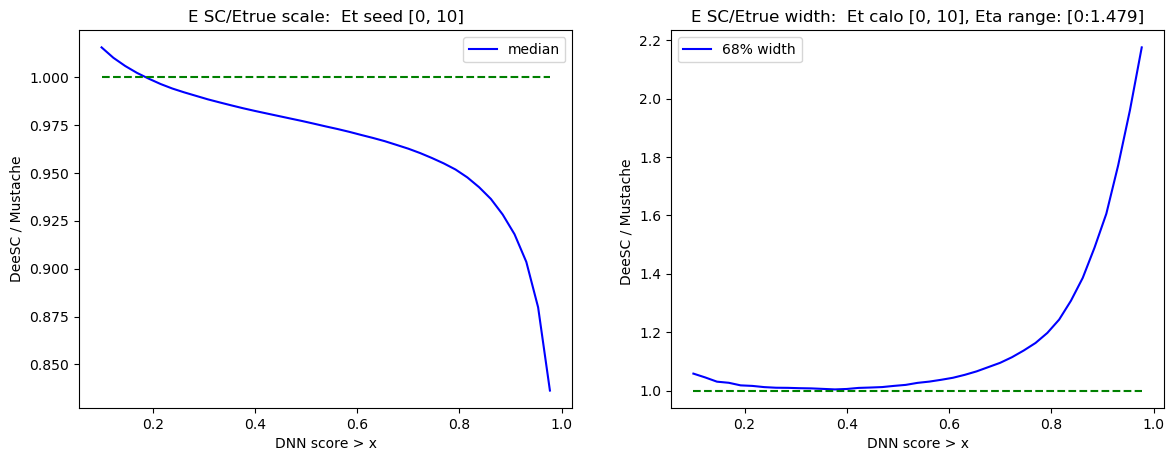

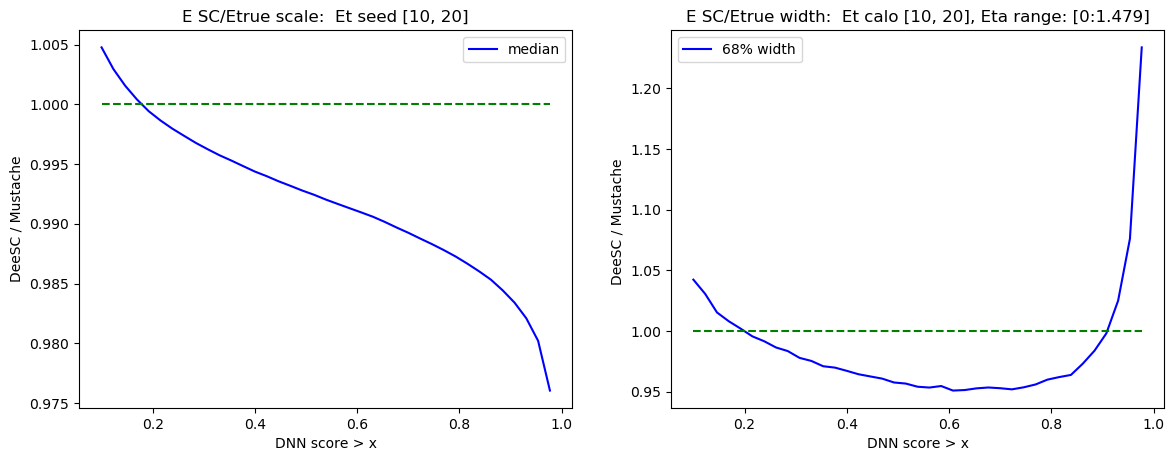

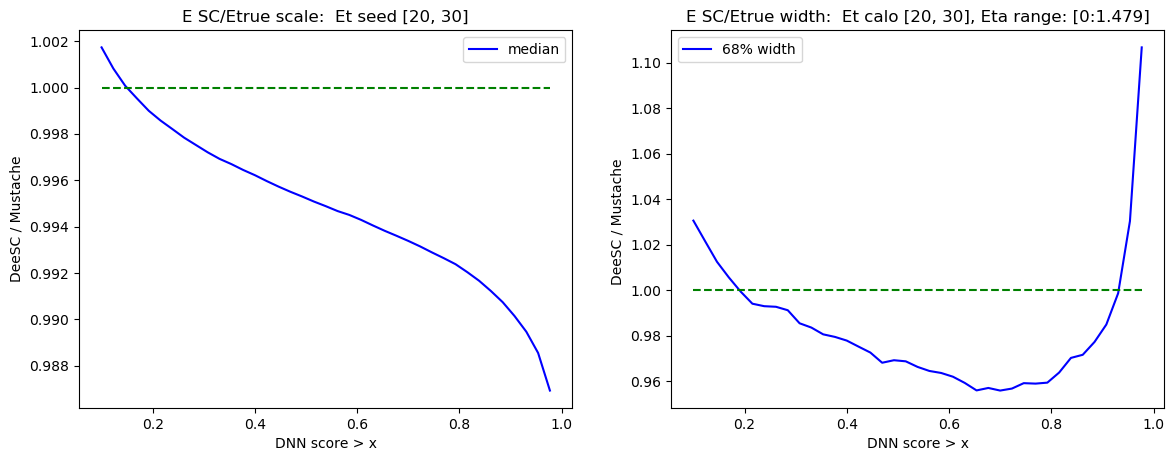

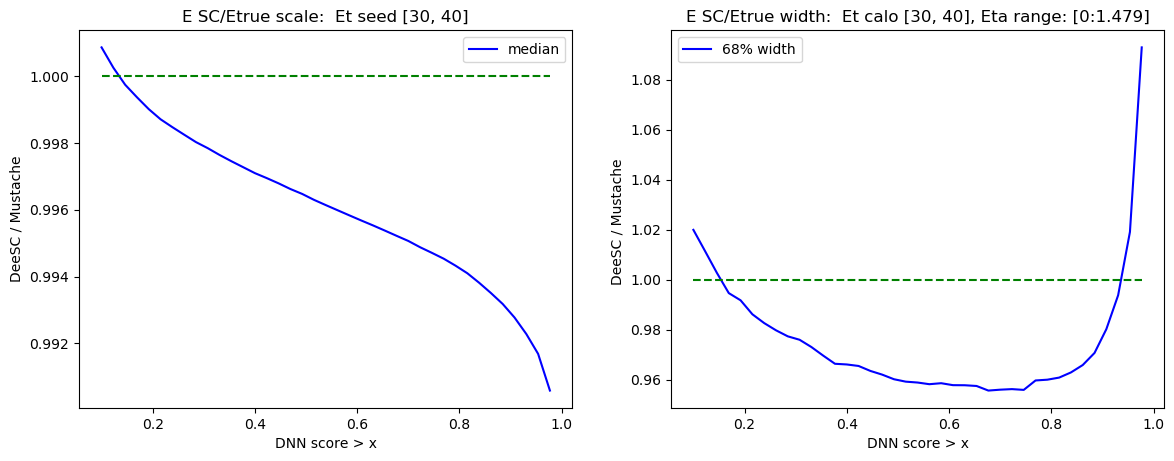

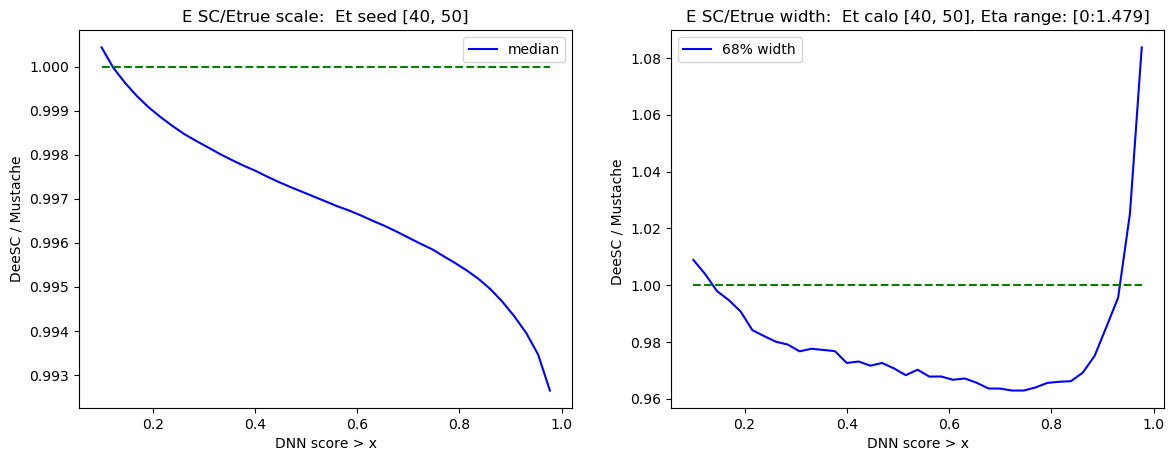

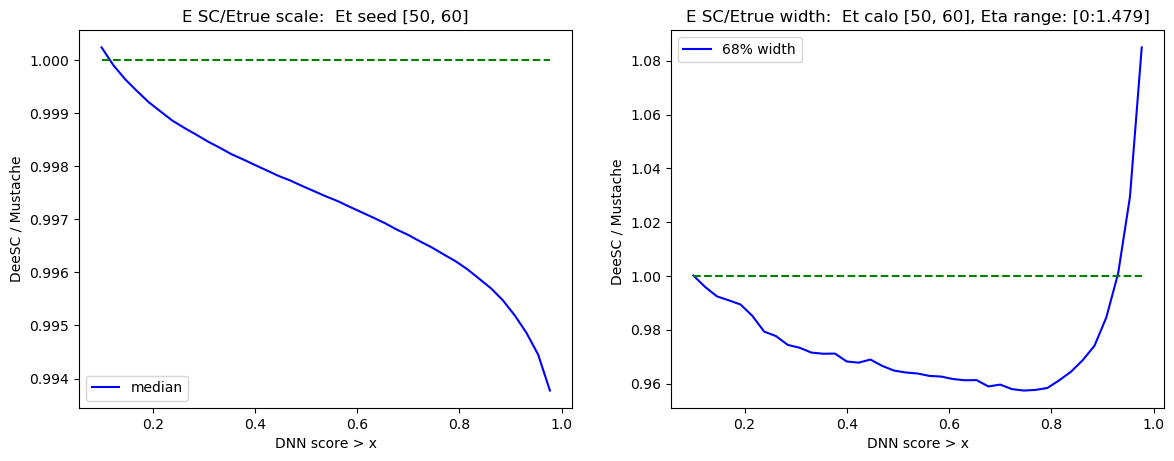

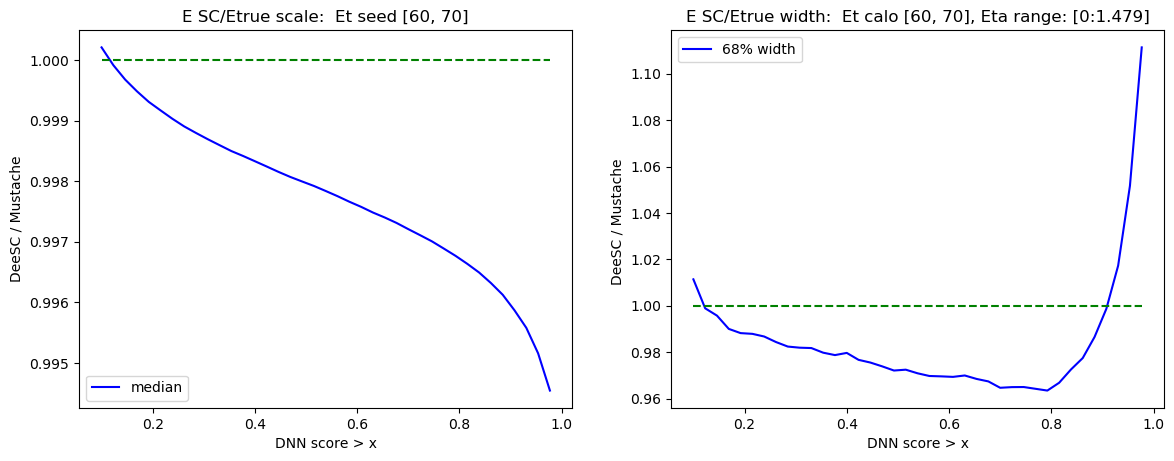

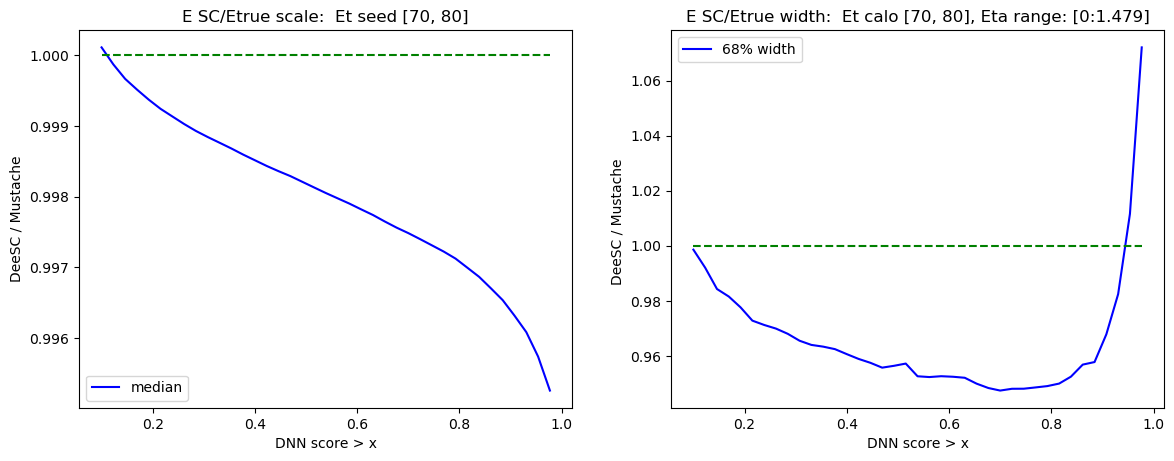

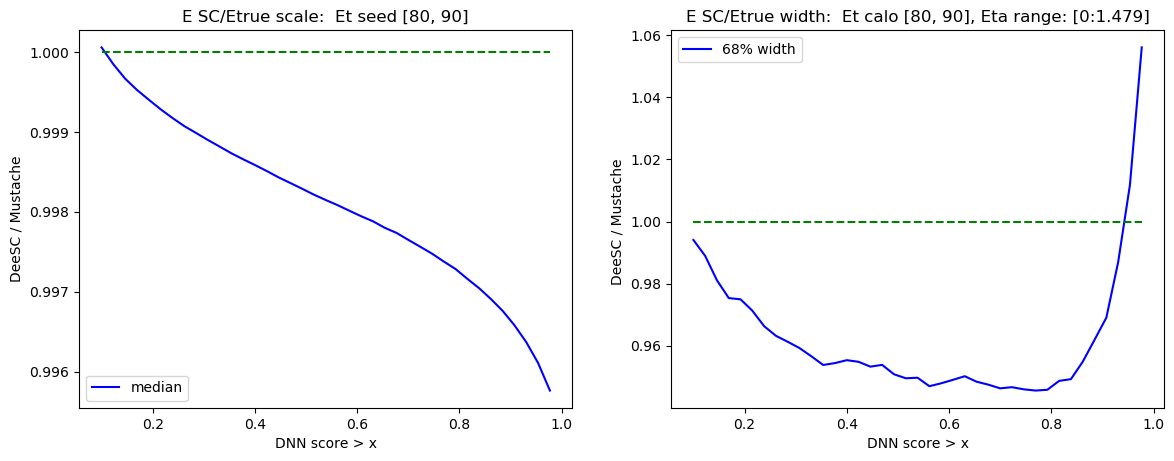

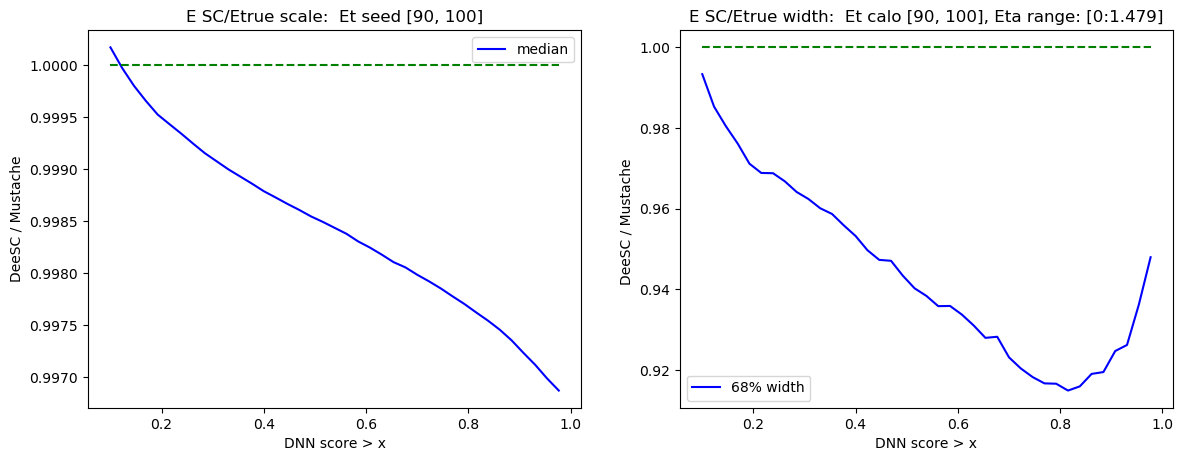

In [17]:
for enbin in range(len(ens)-1):
    
    fig, [ax1,ax2] = plt.subplots(1,2, figsize=(14,5), dpi=100)
    df = result_eb[(result_eb.en_bin==enbin)]
    x = df.dnn_thre.values
    
    # scale
    y = df["EoEtrue_68scale"].values
    y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_68scale"].iloc[0]
    ax1.plot(x, y/y_must, "b",label="median")
    ax1.plot(x, [1.]*len(x), "g--")
    #ax1.plot(x, [y_must]*len(x),"r", label= "Mustache 68% scale")
    
    #y = df["EoEtrue_scale"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_scale"].iloc[0]
    #ax1.plot(x, y/y_must, "r",label="scale")
    #ax1.plot(x, [y_must]*len(x),"r+", label="Mustache scale")
    
    ax1.legend()
    ax1.set_xlabel("DNN score > x")
    ax1.set_ylabel("DeeSC / Mustache")
    ax1.set_title(f"E SC/Etrue scale:  Et seed [{ens[enbin]}, {ens[enbin+1]}]")
    
    ##### width
    y = df["EoEtrue_68width"].values
    y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_68width"].iloc[0]
    
    ax2.plot(x, y/y_must,  "b", label="68% width",)
    ax2.plot(x, [1.]*len(x), "g--")
    #ax2.plot(x, [y_must]*len(x),  "r", label= "Mustache 68% width",)
    
    #y = df["EoEtrue_rms"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_rms"].iloc[0]
    #ax2.plot(x, y/y_must,  "r", label="rms width",)
    #ax3.plot(x, [y_must]*len(x), "r+", label="Mustache scale", )
    
    ax2.legend()
    ax2.set_xlabel("DNN score > x")
    ax2.set_ylabel("DeeSC / Mustache ")
    ax2.set_title(f"E SC/Etrue width:  Et calo [{ens[enbin]}, {ens[enbin+1]}], Eta range: [{eta_range[0]}:{eta_range[1]}]")
    
    fig.savefig(output_dir +f"barrel/scale_width_eta_{eta_range[0]}_{eta_range[1]}_et_{ens[enbin]}_{ens[enbin+1]}_calo.png")
    
    

## By ET calo

In [27]:
eta_range = [0, 1.479]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dnn_thres =  np.linspace(0.1 ,1, 40)[:-1]



results= []

def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    return pd.Series(  
        { 
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (abs(ratio_right-ratio_mean) + abs(ratio_left-ratio_mean))/2, 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std()
        })

for thr in dnn_thres:
    #print("DNN threshold: ", thr)
    g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)< eta_range[1]) &
                 ( (data_val.y >  thr) | (data_val.is_seed==True) ) ].groupby("window_index", sort=False).agg(
                            { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_true": "first",
                              })
    #print(g)
    g["EoEtrue"] = g["en_cluster"] / g["en_true"]
    g["en_bin"] = pd.cut(g["et_true"], ens, labels=list(range(len(ens)-1)))
    
    scanres = g.groupby("en_bin").apply(bin_analysis)
    scanres["dnn_thre"] = thr
    results.append(scanres)

result_eb = pd.concat(results)
#result.columns = ["_".join(col_name).rstrip('_') for col_name in result.columns.to_flat_index()]

# index by en_bin and DNN threshold
result_eb.reset_index(level=0, inplace=True)

g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)<eta_range[1]) &
             ( (data_val.in_mustache==True) | (data_val.is_seed==True)) ].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_true": "first",
                              })
#print(g)
g["EoEtrue"] = g["en_cluster"] / g["en_true"]
g["en_bin"] = pd.cut(g["et_true"], ens, labels=list(range(len(ens)-1)))

result_eb_must = g.groupby("en_bin").apply(bin_analysis)

result_eb_must.reset_index(level=0, inplace=True)


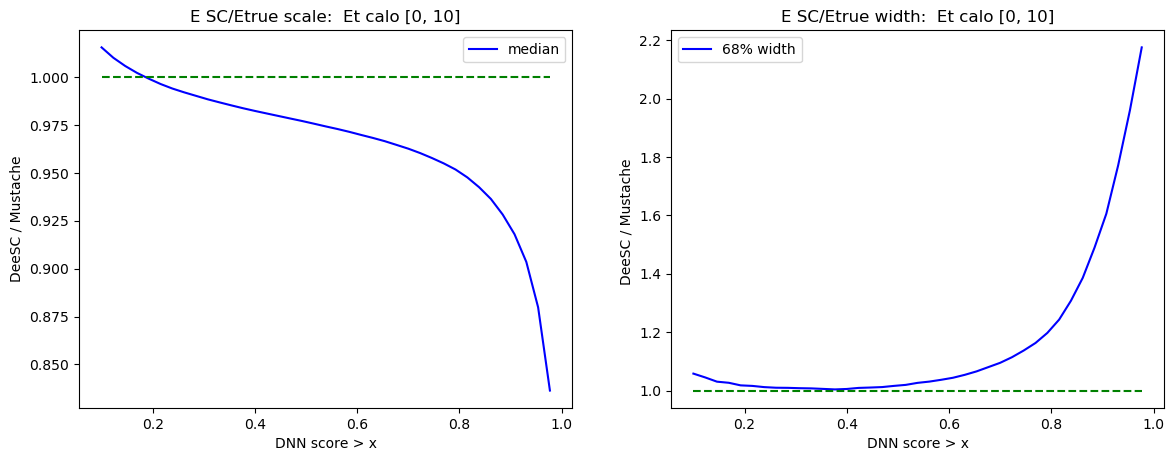

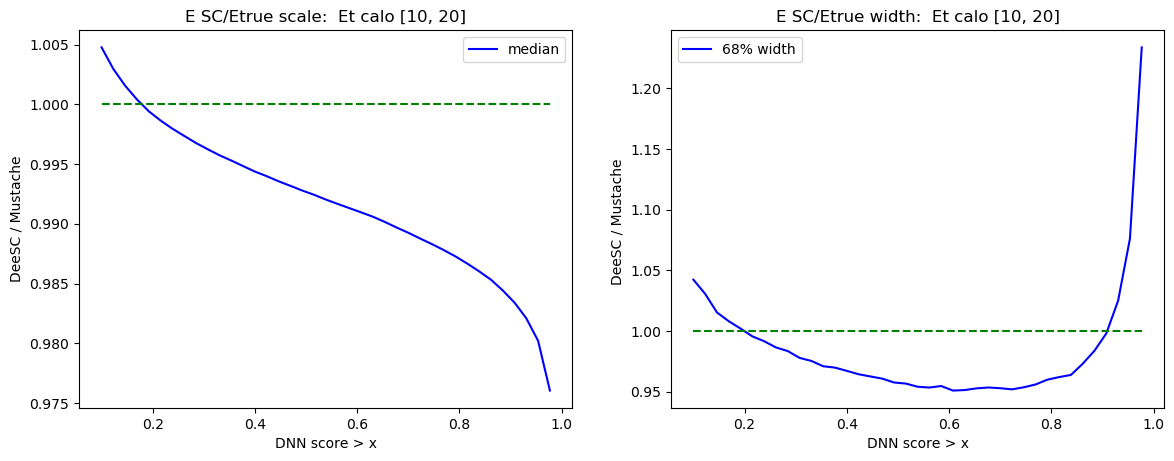

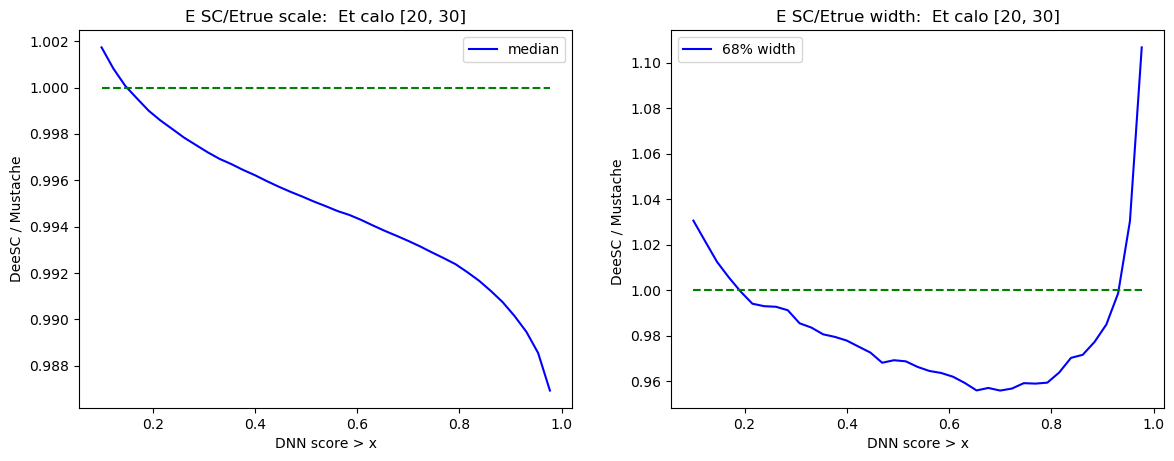

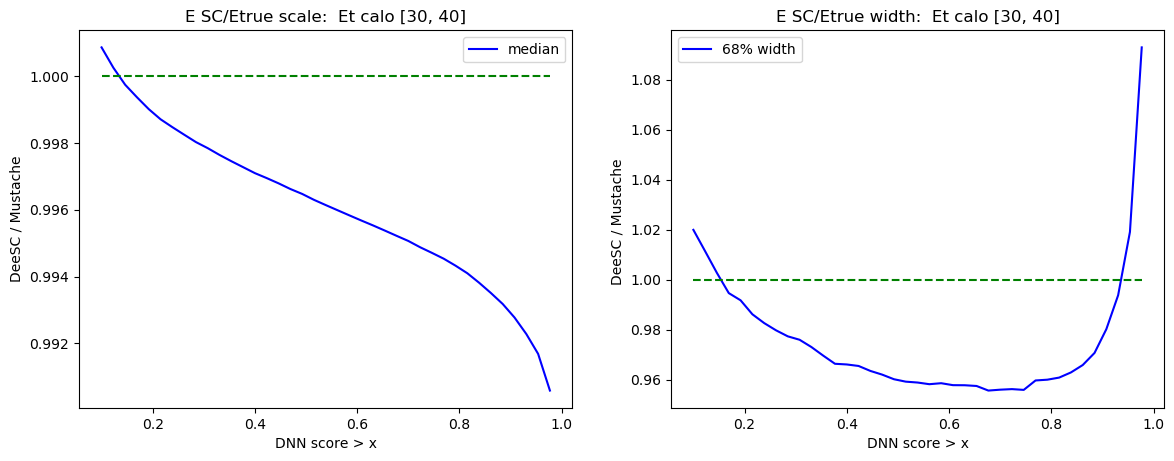

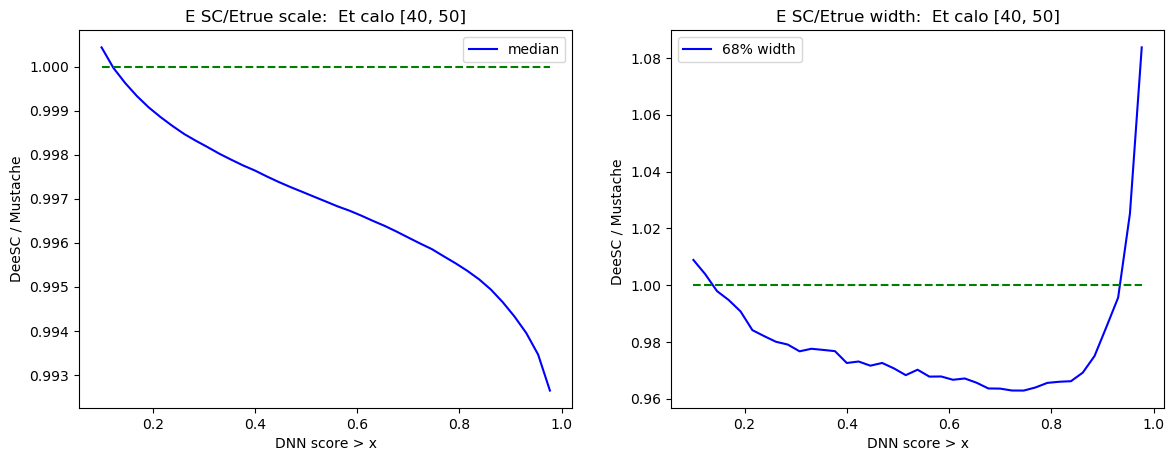

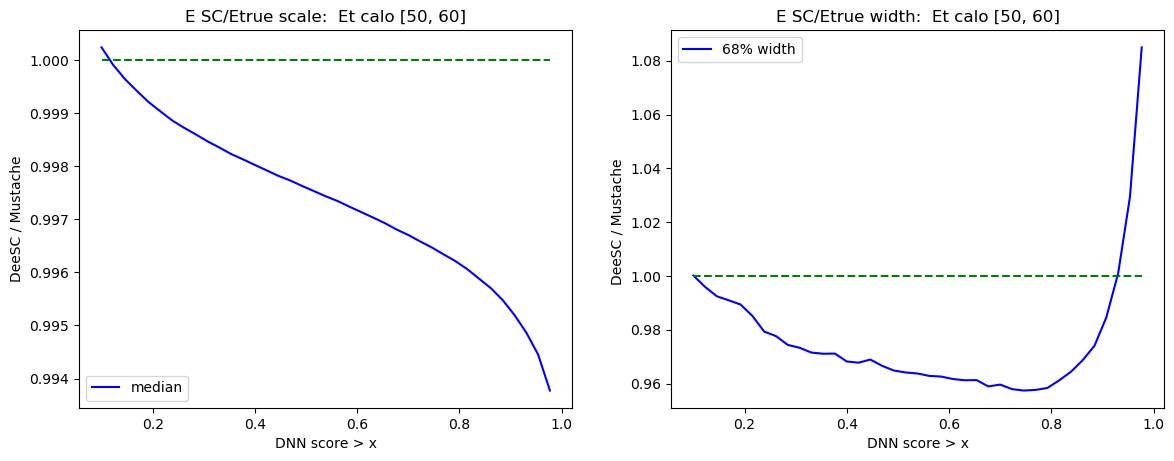

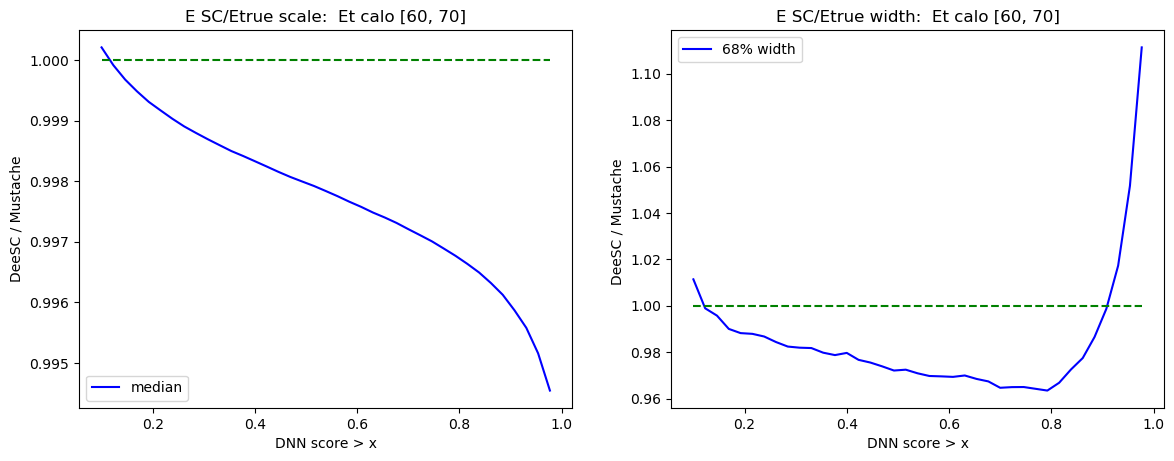

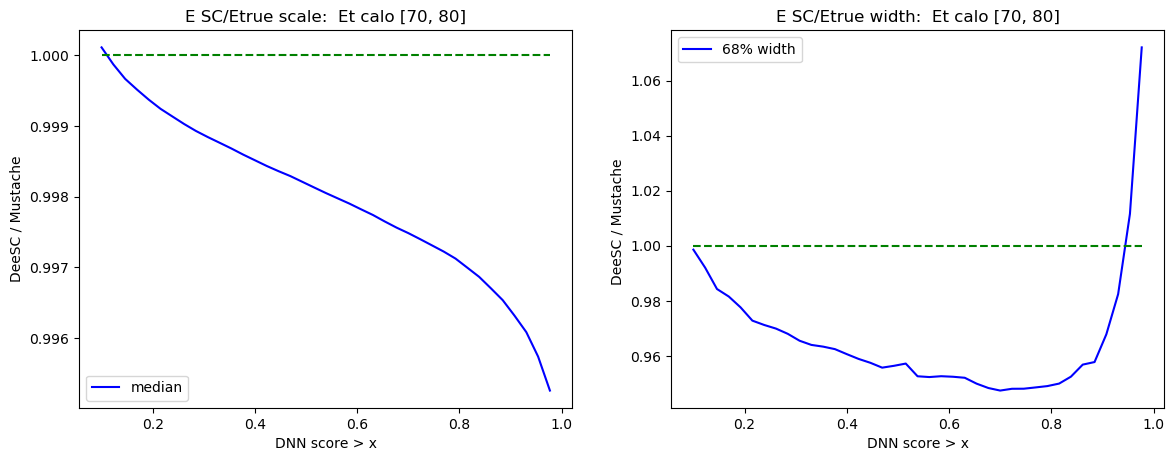

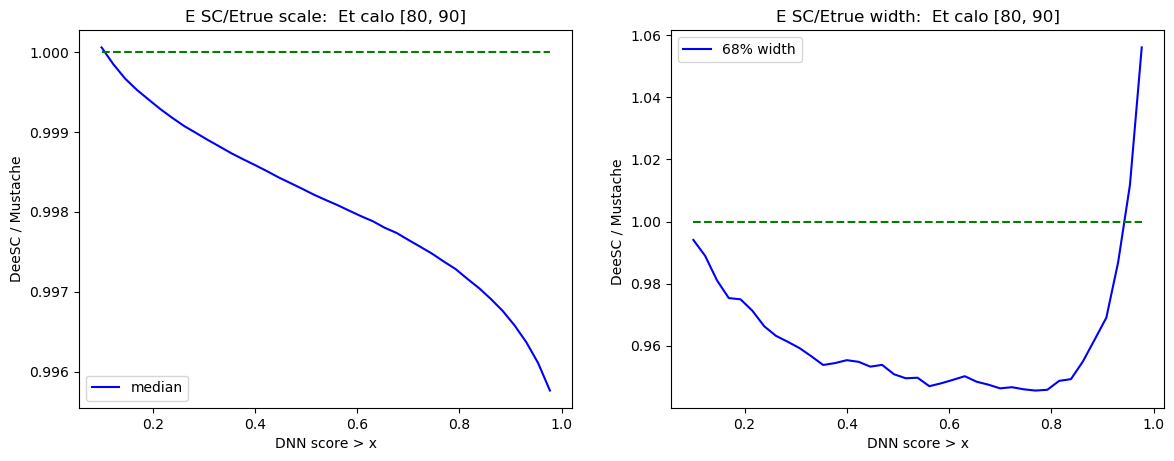

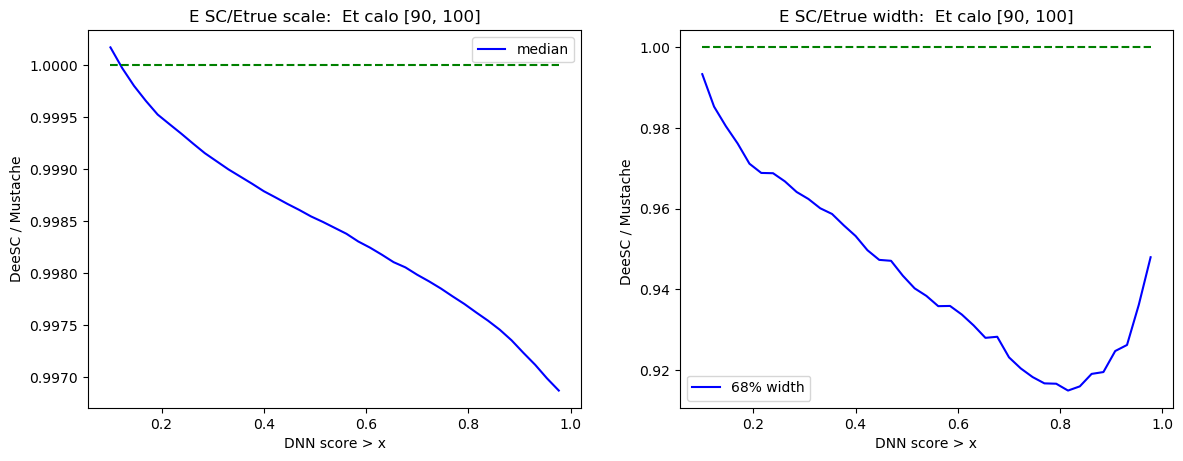

In [16]:
for enbin in range(len(ens)-1):
    
    fig, [ax1,ax2] = plt.subplots(1,2, figsize=(14,5), dpi=100)
    df = result_eb[(result_eb.en_bin==enbin)]
    x = df.dnn_thre.values
    
    # scale
    y = df["EoEtrue_68scale"].values
    y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_68scale"].iloc[0]
    ax1.plot(x, y/y_must, "b",label="median")
    ax1.plot(x, [1.]*len(x), "g--")
    #ax1.plot(x, [y_must]*len(x),"r", label= "Mustache 68% scale")
    
    #y = df["EoEtrue_scale"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_scale"].iloc[0]
    #ax1.plot(x, y/y_must, "r",label="scale")
    #ax1.plot(x, [y_must]*len(x),"r+", label="Mustache scale")
    
    ax1.legend()
    ax1.set_xlabel("DNN score > x")
    ax1.set_ylabel("DeeSC / Mustache")
    ax1.set_title(f"E SC/Etrue scale:  Et calo [{ens[enbin]}, {ens[enbin+1]}]")
    
    ##### width
    y = df["EoEtrue_68width"].values
    y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_68width"].iloc[0]
    
    ax2.plot(x, y/y_must,  "b", label="68% width",)
    ax2.plot(x, [1.]*len(x), "g--")
    #ax2.plot(x, [y_must]*len(x),  "r", label= "Mustache 68% width",)
    
    #y = df["EoEtrue_rms"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_rms"].iloc[0]
    #ax2.plot(x, y/y_must,  "r", label="rms width",)
    #ax3.plot(x, [y_must]*len(x), "r+", label="Mustache scale", )
    
    ax2.legend()
    ax2.set_xlabel("DNN score > x")
    ax2.set_ylabel("DeeSC / Mustache ")
    ax2.set_title(f"E SC/Etrue width:  Et calo [{ens[enbin]}, {ens[enbin+1]}]")
    
    fig.savefig(output_dir +f"barrel/scale_width_et_{ens[enbin]}_{ens[enbin+1]}_calo.png")
    

## Endcap

## By et seed

In [22]:
eta_range = [1.75,3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#ens= [0,1,2,3,5,8,10,20,100]
dnn_thres =  np.linspace(0.2 ,1, 40)[:-1]


results= []

for thr in dnn_thres:
    #print("DNN threshold: ", thr)
    g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)< eta_range[1]) &
                 ( (data_val.y >  thr) | (data_val.is_seed==True) ) ].groupby("window_index", sort=False).agg(
                            { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_seed": "first",
                              })
    #print(g)
    g["EoEtrue"] = g["en_cluster"] / g["en_true"]
    g["en_bin"] = pd.cut(g["et_seed"], ens, labels=list(range(len(ens)-1)))
    
    scanres = g.groupby("en_bin").apply(bin_analysis)
    scanres["dnn_thre"] = thr
    results.append(scanres)

result_ee = pd.concat(results)
#result.columns = ["_".join(col_name).rstrip('_') for col_name in result.columns.to_flat_index()]

# index by en_bin and DNN threshold
result_ee.reset_index(level=0, inplace=True)


g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)<eta_range[1]) &
             ( (data_val.in_mustache==True) | (data_val.is_seed==True)) ].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_seed": "first",
                              })
#print(g)
g["EoEtrue"] = g["en_cluster"] / g["en_true"]
g["en_bin"] = pd.cut(g["et_seed"], ens, labels=list(range(len(ens)-1)))

result_ee_must = g.groupby("en_bin").apply(bin_analysis)

result_ee_must.reset_index(level=0, inplace=True)

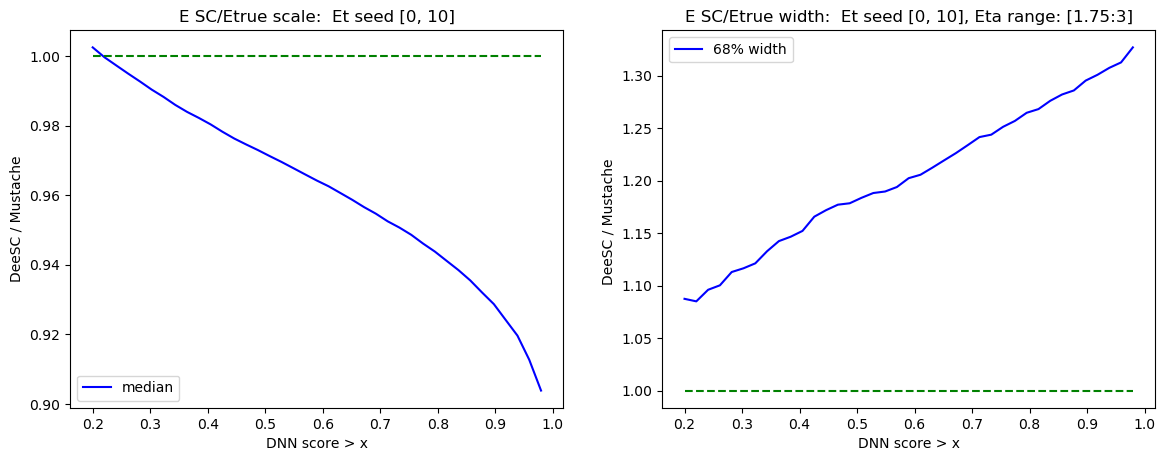

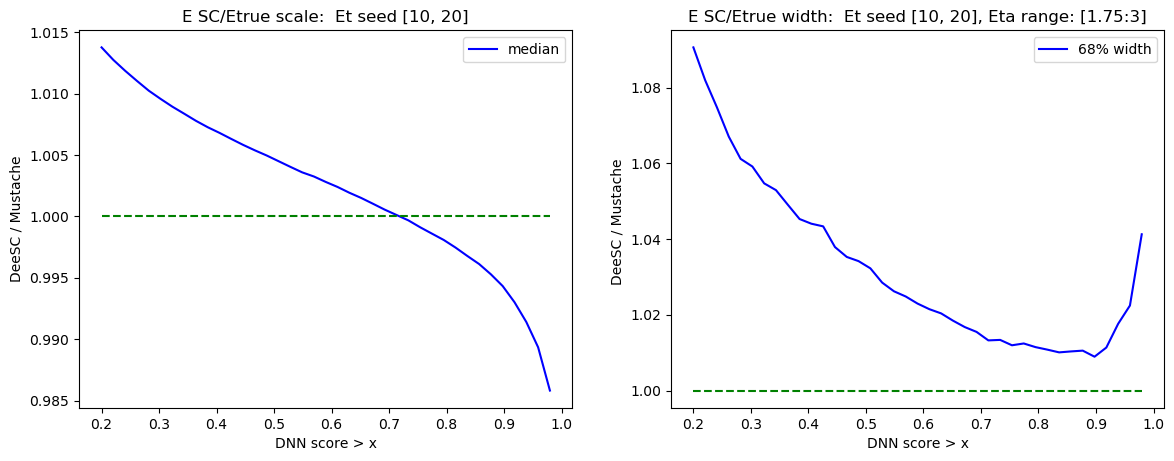

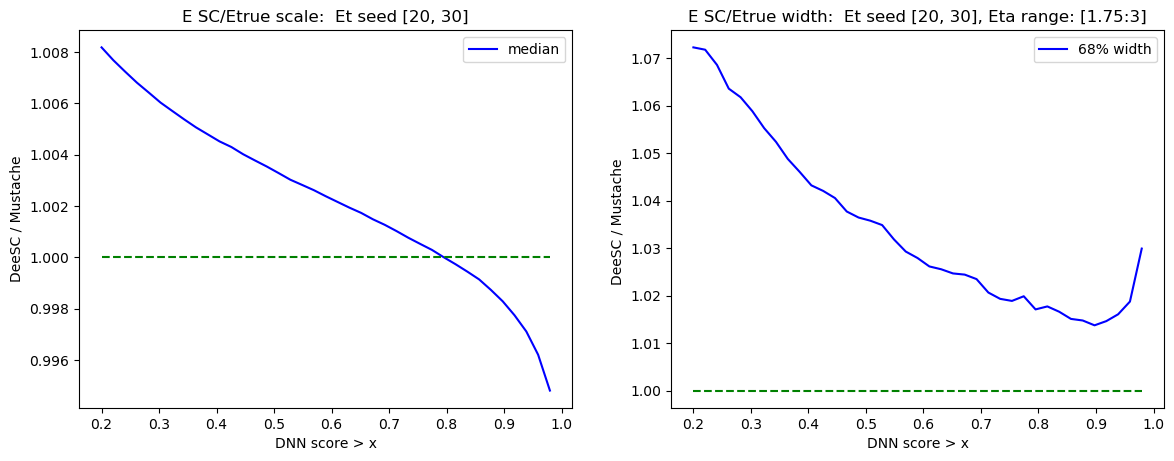

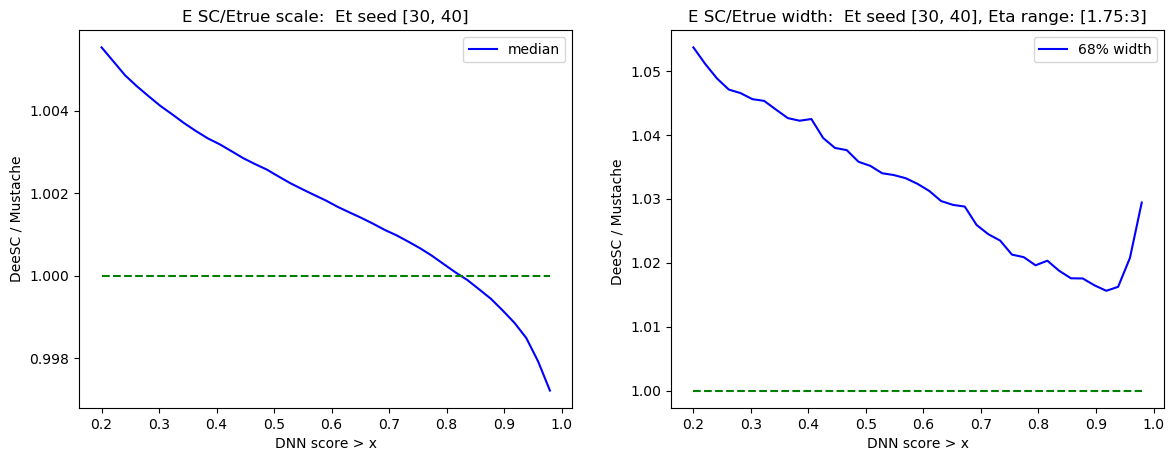

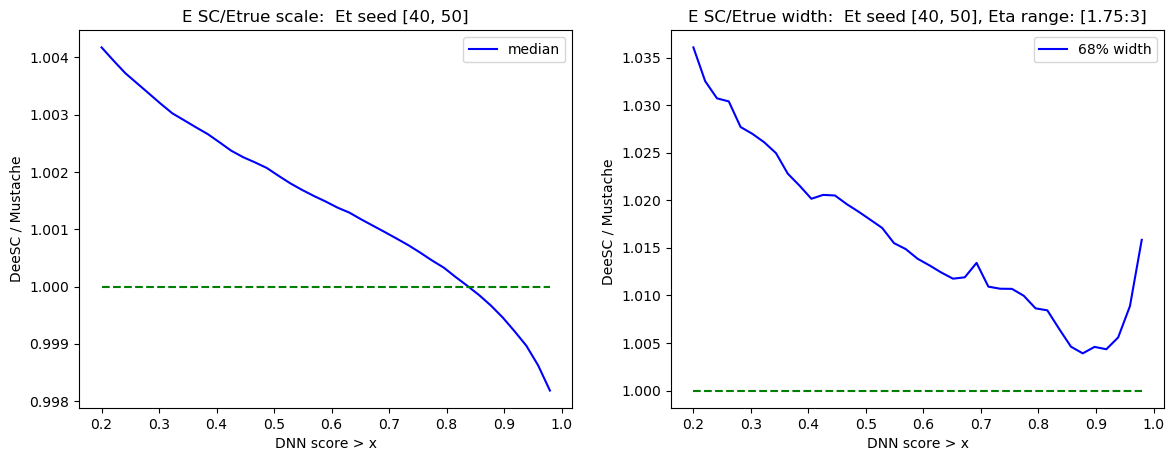

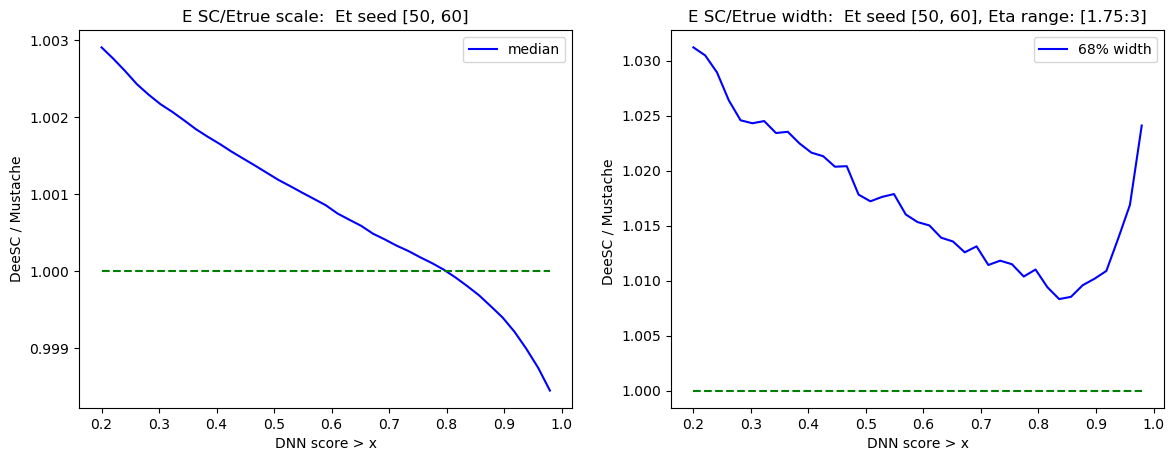

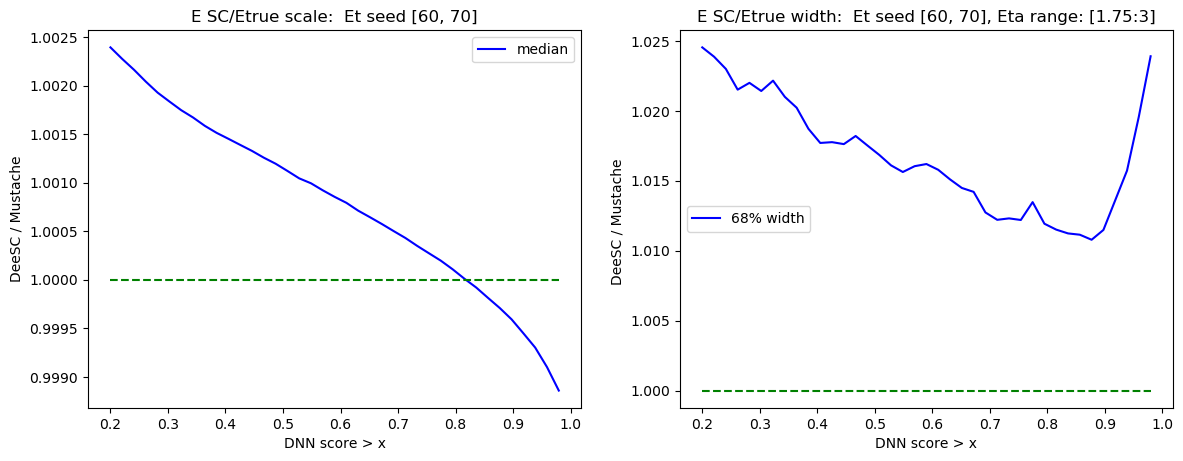

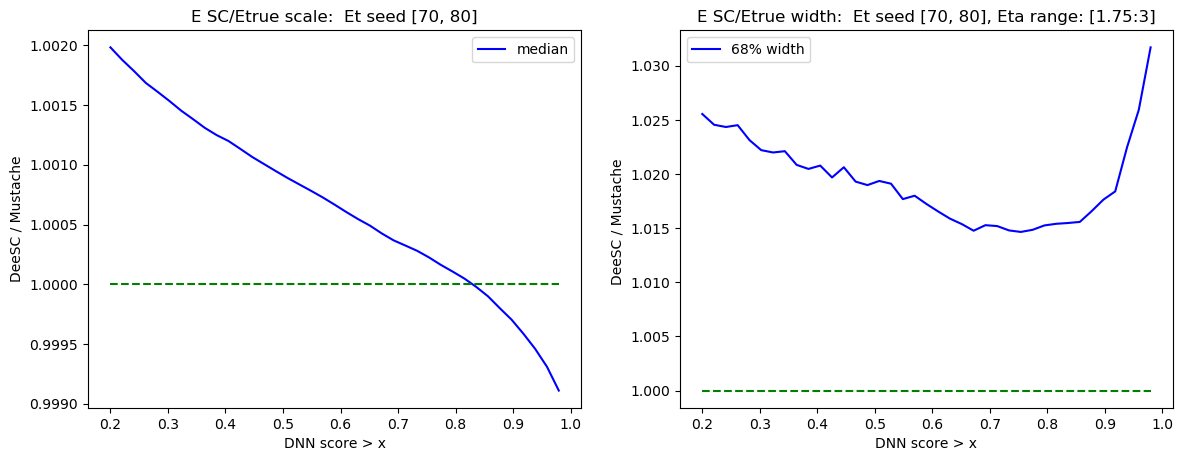

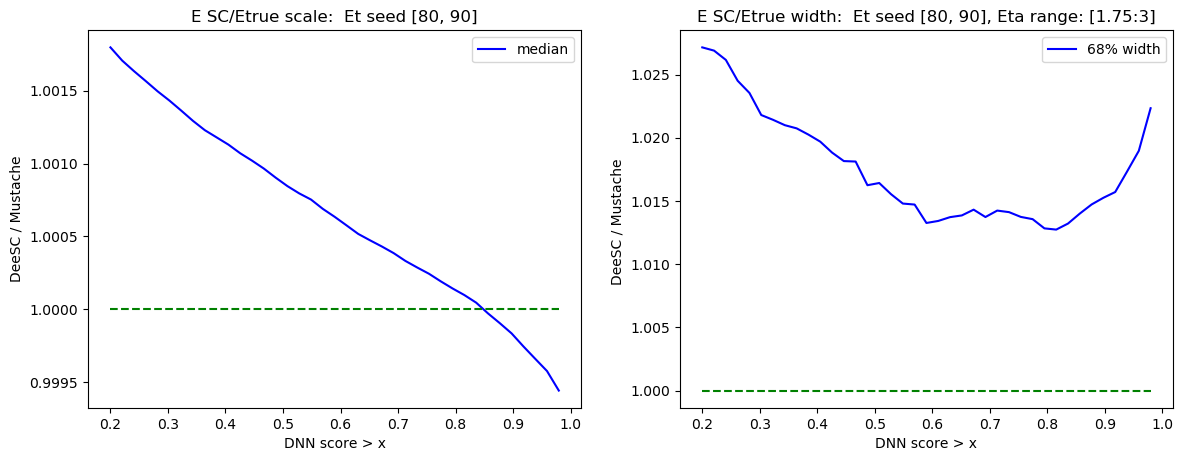

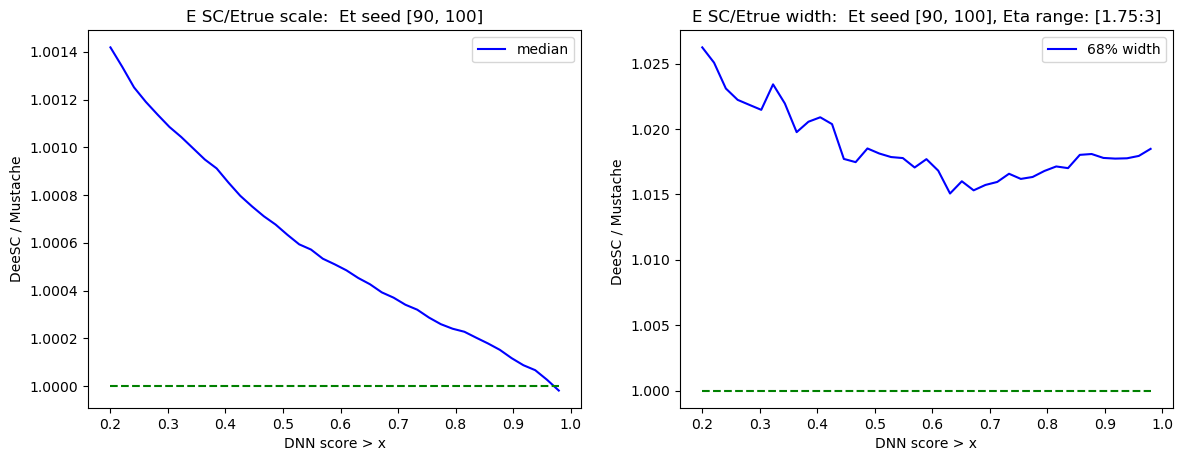

In [23]:
for enbin in range(len(ens)-1):
    
    fig, [ax1,ax2] = plt.subplots(1,2, figsize=(14,5), dpi=100)
    df = result_ee[(result_ee.en_bin==enbin)]
    x = df.dnn_thre.values
    
    # scale
    y = df["EoEtrue_68scale"].values
    y_must = result_ee_must[result_ee_must.en_bin==enbin]["EoEtrue_68scale"].iloc[0]
    ax1.plot(x, y/y_must, "b",label="median")
    ax1.plot(x, [1.]*len(x), "g--")
    #ax1.plot(x, [y_must]*len(x),"r", label= "Mustache 68% scale")
    
    #y = df["EoEtrue_scale"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_scale"].iloc[0]
    #ax1.plot(x, y/y_must, "r",label="scale")
    #ax1.plot(x, [y_must]*len(x),"r+", label="Mustache scale")
    
    ax1.legend()
    ax1.set_xlabel("DNN score > x")
    ax1.set_ylabel("DeeSC / Mustache")
    ax1.set_title(f"E SC/Etrue scale:  Et seed [{ens[enbin]}, {ens[enbin+1]}]")
    
    ##### width
    y = df["EoEtrue_68width"].values
    y_must = result_ee_must[result_ee_must.en_bin==enbin]["EoEtrue_68width"].iloc[0]
    
    ax2.plot(x, y/y_must,  "b", label="68% width",)
    ax2.plot(x, [1.]*len(x), "g--")
    #ax2.plot(x, [y_must]*len(x),  "r", label= "Mustache 68% width",)
    
    #y = df["EoEtrue_rms"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_rms"].iloc[0]
    #ax2.plot(x, y/y_must,  "r", label="rms width",)
    #ax3.plot(x, [y_must]*len(x), "r+", label="Mustache scale", )
    
    ax2.legend()
    ax2.set_xlabel("DNN score > x")
    ax2.set_ylabel("DeeSC / Mustache ")
    ax2.set_title(f"E SC/Etrue width:  Et seed [{ens[enbin]}, {ens[enbin+1]}], Eta range: [{eta_range[0]}:{eta_range[1]}]")
    
    fig.savefig(output_dir +f"endcap/scale_width_eta_{eta_range[0]}_{eta_range[1]}_et_{ens[enbin]}_{ens[enbin+1]}_seed.png")
    

## Et calo

In [35]:
eta_range = [1.75, 3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dnn_thres =  np.linspace(0.2 ,1, 40)[:-1]


results= []


for thr in dnn_thres:
    #print("DNN threshold: ", thr)
    g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)< eta_range[1]) &
                 ( (data_val.y >  thr) | (data_val.is_seed==True) ) ].groupby("window_index", sort=False).agg(
                            { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_true": "first",
                              })
    #print(g)
    g["EoEtrue"] = g["en_cluster"] / g["en_true"]
    g["en_bin"] = pd.cut(g["et_true"], ens, labels=list(range(len(ens)-1)))
    
    scanres = g.groupby("en_bin").apply(bin_analysis)
    scanres["dnn_thre"] = thr
    results.append(scanres)

result_ee = pd.concat(results)
#result.columns = ["_".join(col_name).rstrip('_') for col_name in result.columns.to_flat_index()]

# index by en_bin and DNN threshold
result_ee.reset_index(level=0, inplace=True)

g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)<eta_range[1]) &
             ( (data_val.in_mustache==True) | (data_val.is_seed==True)) ].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_true": "first",
                              })
#print(g)
g["EoEtrue"] = g["en_cluster"] / g["en_true"]
g["en_bin"] = pd.cut(g["et_true"], ens, labels=list(range(len(ens)-1)))

result_ee_must = g.groupby("en_bin").apply(bin_analysis)

result_ee_must.reset_index(level=0, inplace=True)

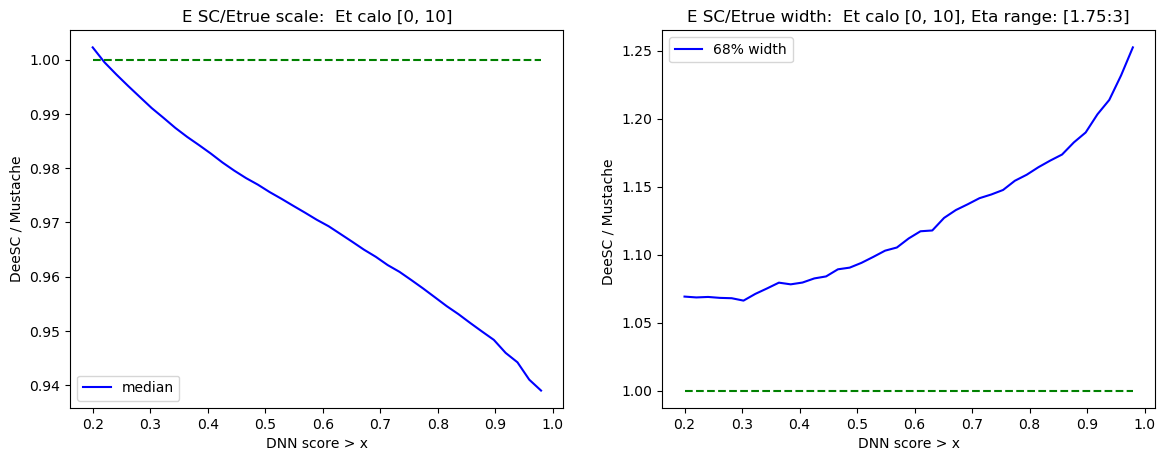

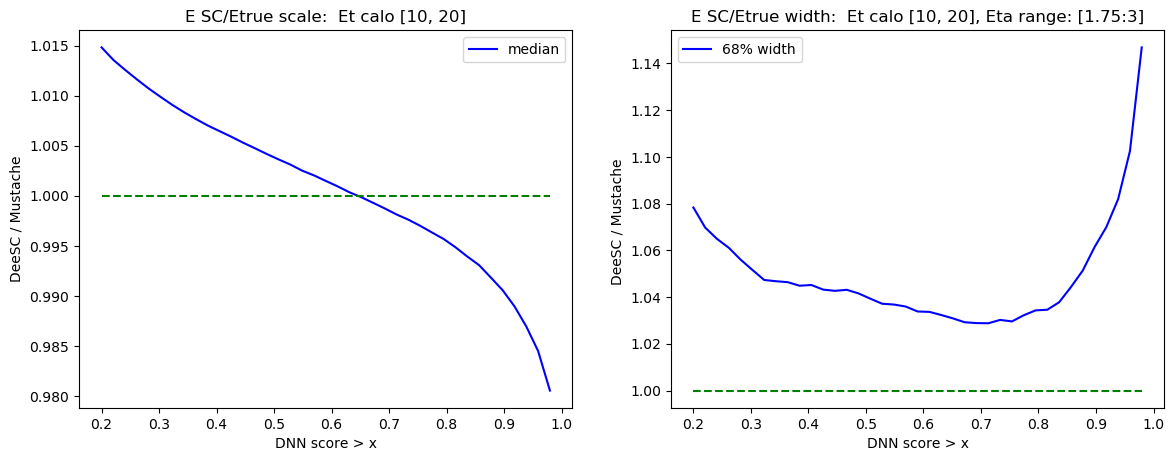

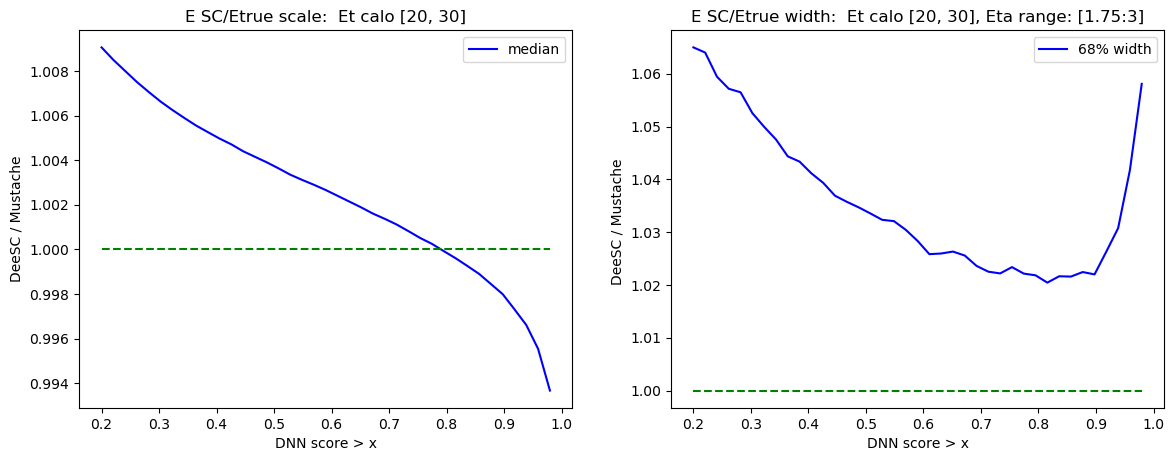

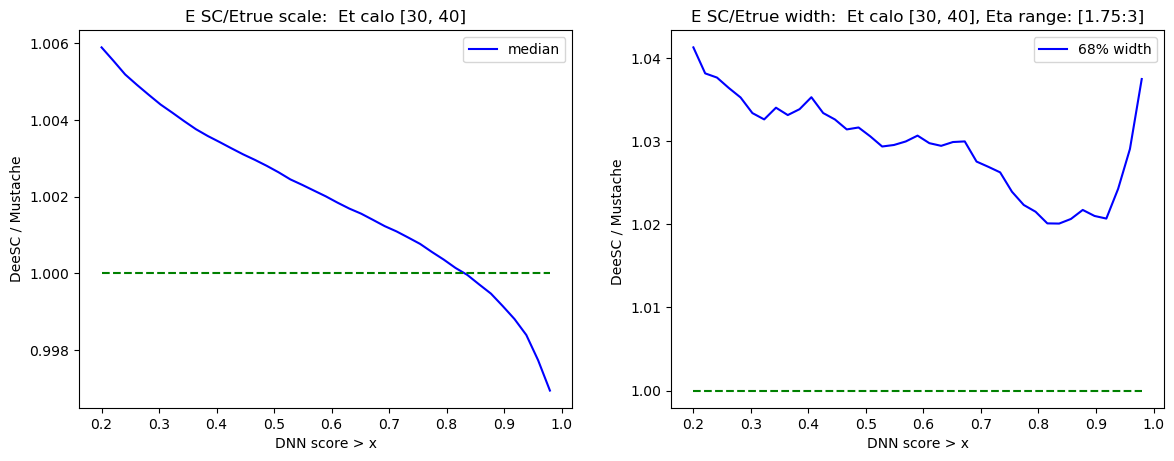

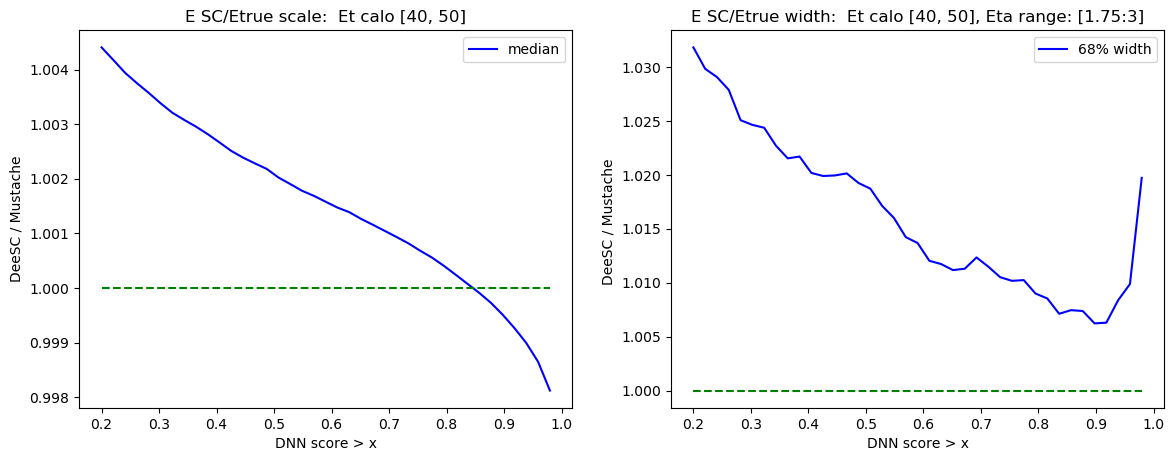

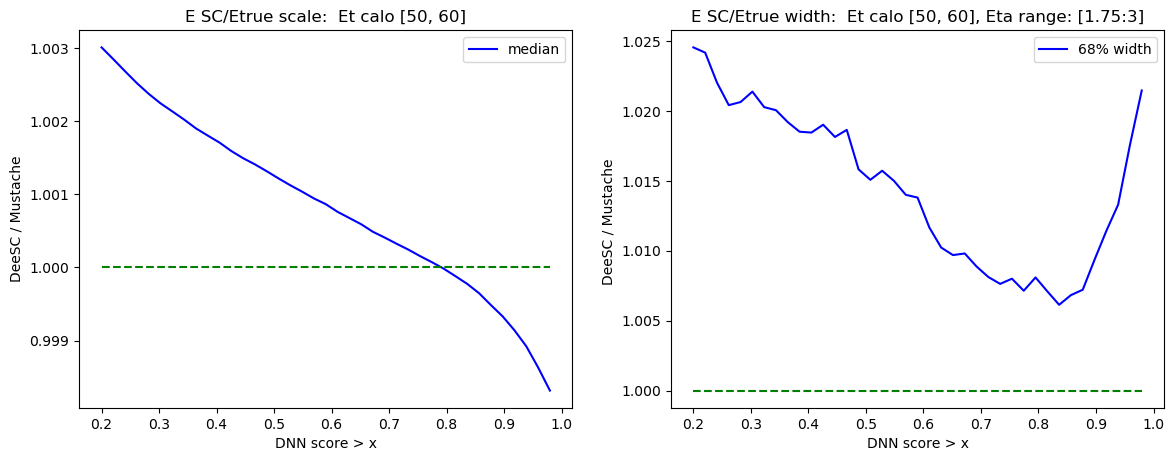

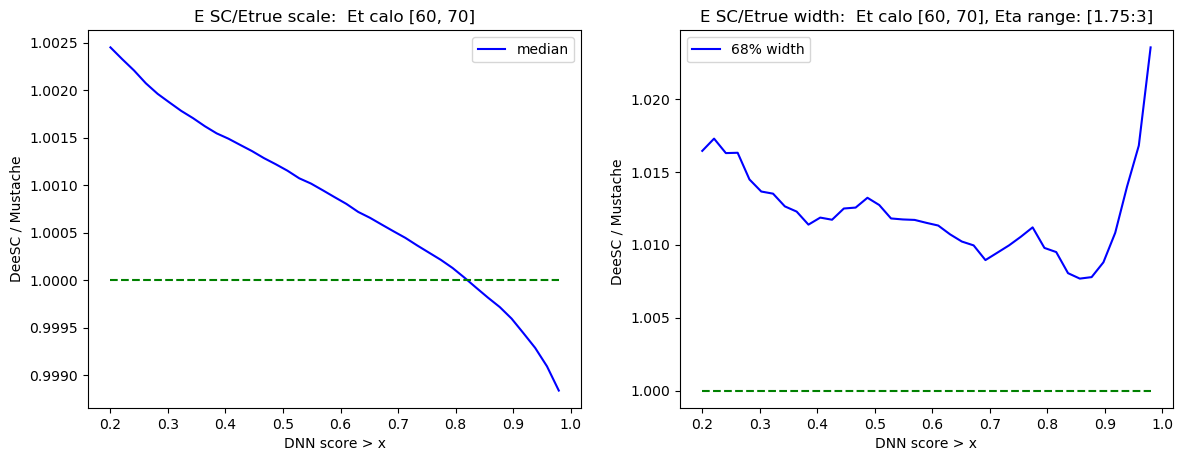

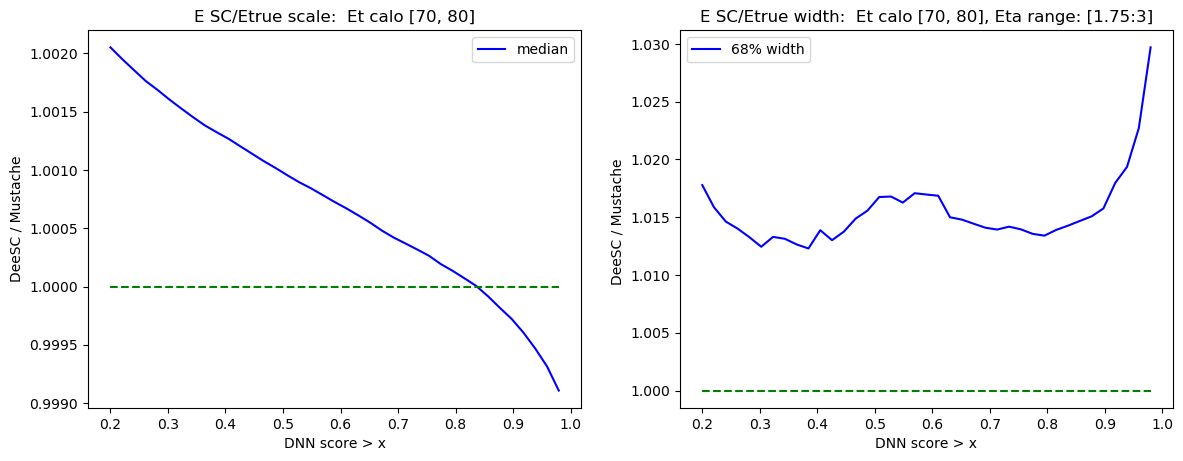

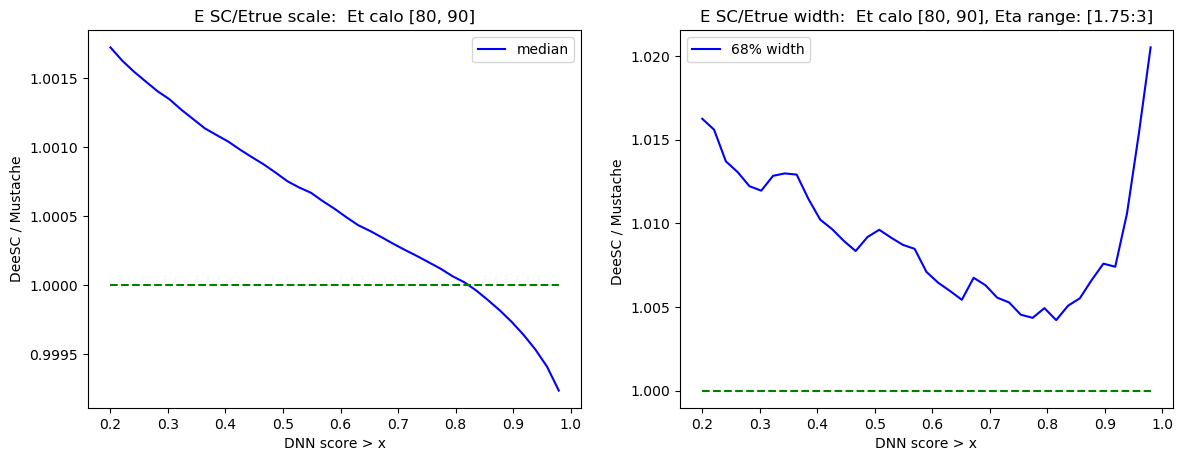

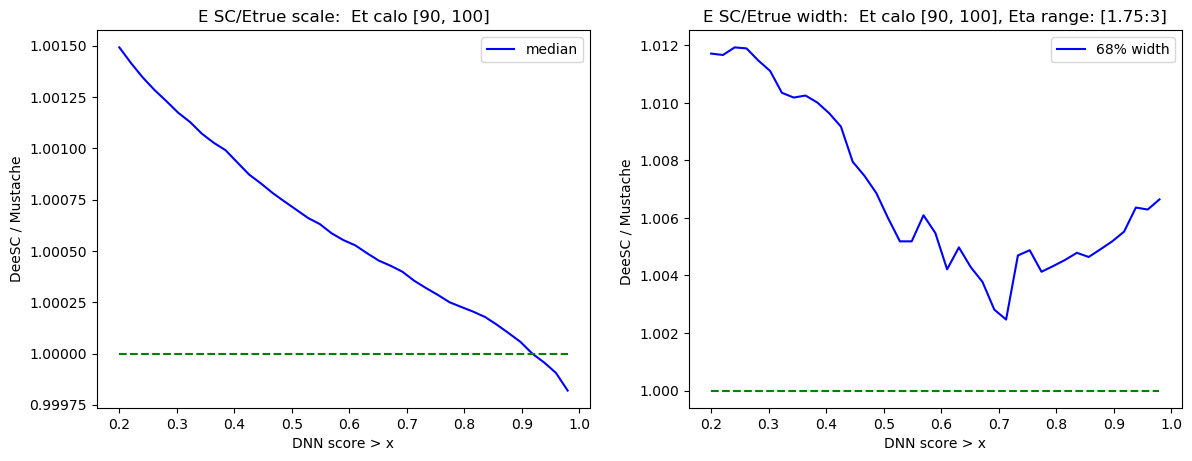

In [36]:
for enbin in range(len(ens)-1):
    
    fig, [ax1,ax2] = plt.subplots(1,2, figsize=(14,5), dpi=100)
    df = result_ee[(result_ee.en_bin==enbin)]
    x = df.dnn_thre.values
    
    # scale
    y = df["EoEtrue_68scale"].values
    y_must = result_ee_must[result_ee_must.en_bin==enbin]["EoEtrue_68scale"].iloc[0]
    ax1.plot(x, y/y_must, "b",label="median")
    ax1.plot(x, [1.]*len(x), "g--")
    #ax1.plot(x, [y_must]*len(x),"r", label= "Mustache 68% scale")
    
    #y = df["EoEtrue_scale"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_scale"].iloc[0]
    #ax1.plot(x, y/y_must, "r",label="scale")
    #ax1.plot(x, [y_must]*len(x),"r+", label="Mustache scale")
    
    ax1.legend()
    ax1.set_xlabel("DNN score > x")
    ax1.set_ylabel("DeeSC / Mustache")
    ax1.set_title(f"E SC/Etrue scale:  Et calo [{ens[enbin]}, {ens[enbin+1]}]")
    
    ##### width
    y = df["EoEtrue_68width"].values
    y_must = result_ee_must[result_ee_must.en_bin==enbin]["EoEtrue_68width"].iloc[0]
    
    ax2.plot(x, y/y_must,  "b", label="68% width",)
    ax2.plot(x, [1.]*len(x), "g--")
    #ax2.plot(x, [y_must]*len(x),  "r", label= "Mustache 68% width",)
    
    #y = df["EoEtrue_rms"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_rms"].iloc[0]
    #ax2.plot(x, y/y_must,  "r", label="rms width",)
    #ax3.plot(x, [y_must]*len(x), "r+", label="Mustache scale", )
    
    ax2.legend()
    ax2.set_xlabel("DNN score > x")
    ax2.set_ylabel("DeeSC / Mustache ")
    ax2.set_title(f"E SC/Etrue width:  Et calo [{ens[enbin]}, {ens[enbin+1]}], Eta range: [{eta_range[0]}:{eta_range[1]}]")
    
    fig.savefig(output_dir +f"endcap/scale_width_eta_{eta_range[0]}_{eta_range[1]}_et_{ens[enbin]}_{ens[enbin+1]}_calo.png")
    

# Signal and bkg efficiencies by $\eta$ and Pt


In [49]:
etas = [0, 0.2, 0.4 ,0.6, 0.8, 1, 1.2, 1.4, 1.479, 1.75, 2, 2.25, 3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#etas = [0, 1, 2]
#ens= [0, 50, 100]
threshold = 0.88

results = np.zeros((len(etas)-1, len(ens)-1, 2))

data_in = data_in[data_in.is_seed==False]
data_out = data_out[data_out.is_seed==False]

y = "y_shower"

for ieta in range(len(etas)-1):
    for ien in range(len(ens)-1):
        eta_min = etas[ieta]
        eta_max = etas[ieta+1]
        et_min = ens[ien]
        et_max = ens[ien+1]
        print(eta_min, eta_max, et_min, et_max)
        
        data_out_tot = data_out[(abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                            (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ].size
        data_out_1 = data_out[(data_out[y] > threshold) & (abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                            (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ].size
        data_in_tot = data_in[ (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                            (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ].size
        data_in_1 = data_in[(data_in[y] > threshold) & (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                            (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ].size
        
        results[ieta, ien, :] = np.array([data_in_1 / data_in_tot , data_out_1 / data_out_tot])

0 0.2 0 10
0 0.2 10 20
0 0.2 20 30
0 0.2 30 40
0 0.2 40 50
0 0.2 50 60
0 0.2 60 70
0 0.2 70 80
0 0.2 80 90
0 0.2 90 100
0.2 0.4 0 10
0.2 0.4 10 20
0.2 0.4 20 30
0.2 0.4 30 40
0.2 0.4 40 50
0.2 0.4 50 60
0.2 0.4 60 70
0.2 0.4 70 80
0.2 0.4 80 90
0.2 0.4 90 100
0.4 0.6 0 10
0.4 0.6 10 20
0.4 0.6 20 30
0.4 0.6 30 40
0.4 0.6 40 50
0.4 0.6 50 60
0.4 0.6 60 70
0.4 0.6 70 80
0.4 0.6 80 90
0.4 0.6 90 100
0.6 0.8 0 10
0.6 0.8 10 20
0.6 0.8 20 30
0.6 0.8 30 40
0.6 0.8 40 50
0.6 0.8 50 60
0.6 0.8 60 70
0.6 0.8 70 80
0.6 0.8 80 90
0.6 0.8 90 100
0.8 1 0 10
0.8 1 10 20
0.8 1 20 30
0.8 1 30 40
0.8 1 40 50
0.8 1 50 60
0.8 1 60 70
0.8 1 70 80
0.8 1 80 90
0.8 1 90 100
1 1.2 0 10
1 1.2 10 20
1 1.2 20 30
1 1.2 30 40
1 1.2 40 50
1 1.2 50 60
1 1.2 60 70
1 1.2 70 80
1 1.2 80 90
1 1.2 90 100
1.2 1.4 0 10
1.2 1.4 10 20
1.2 1.4 20 30
1.2 1.4 30 40
1.2 1.4 40 50
1.2 1.4 50 60
1.2 1.4 60 70
1.2 1.4 70 80
1.2 1.4 80 90
1.2 1.4 90 100
1.4 1.479 0 10
1.4 1.479 10 20
1.4 1.479 20 30
1.4 1.479 30 40
1.4 1.479 40 50
1

Text(0.55, 0.92, 'Wrong cluster selection eff.')

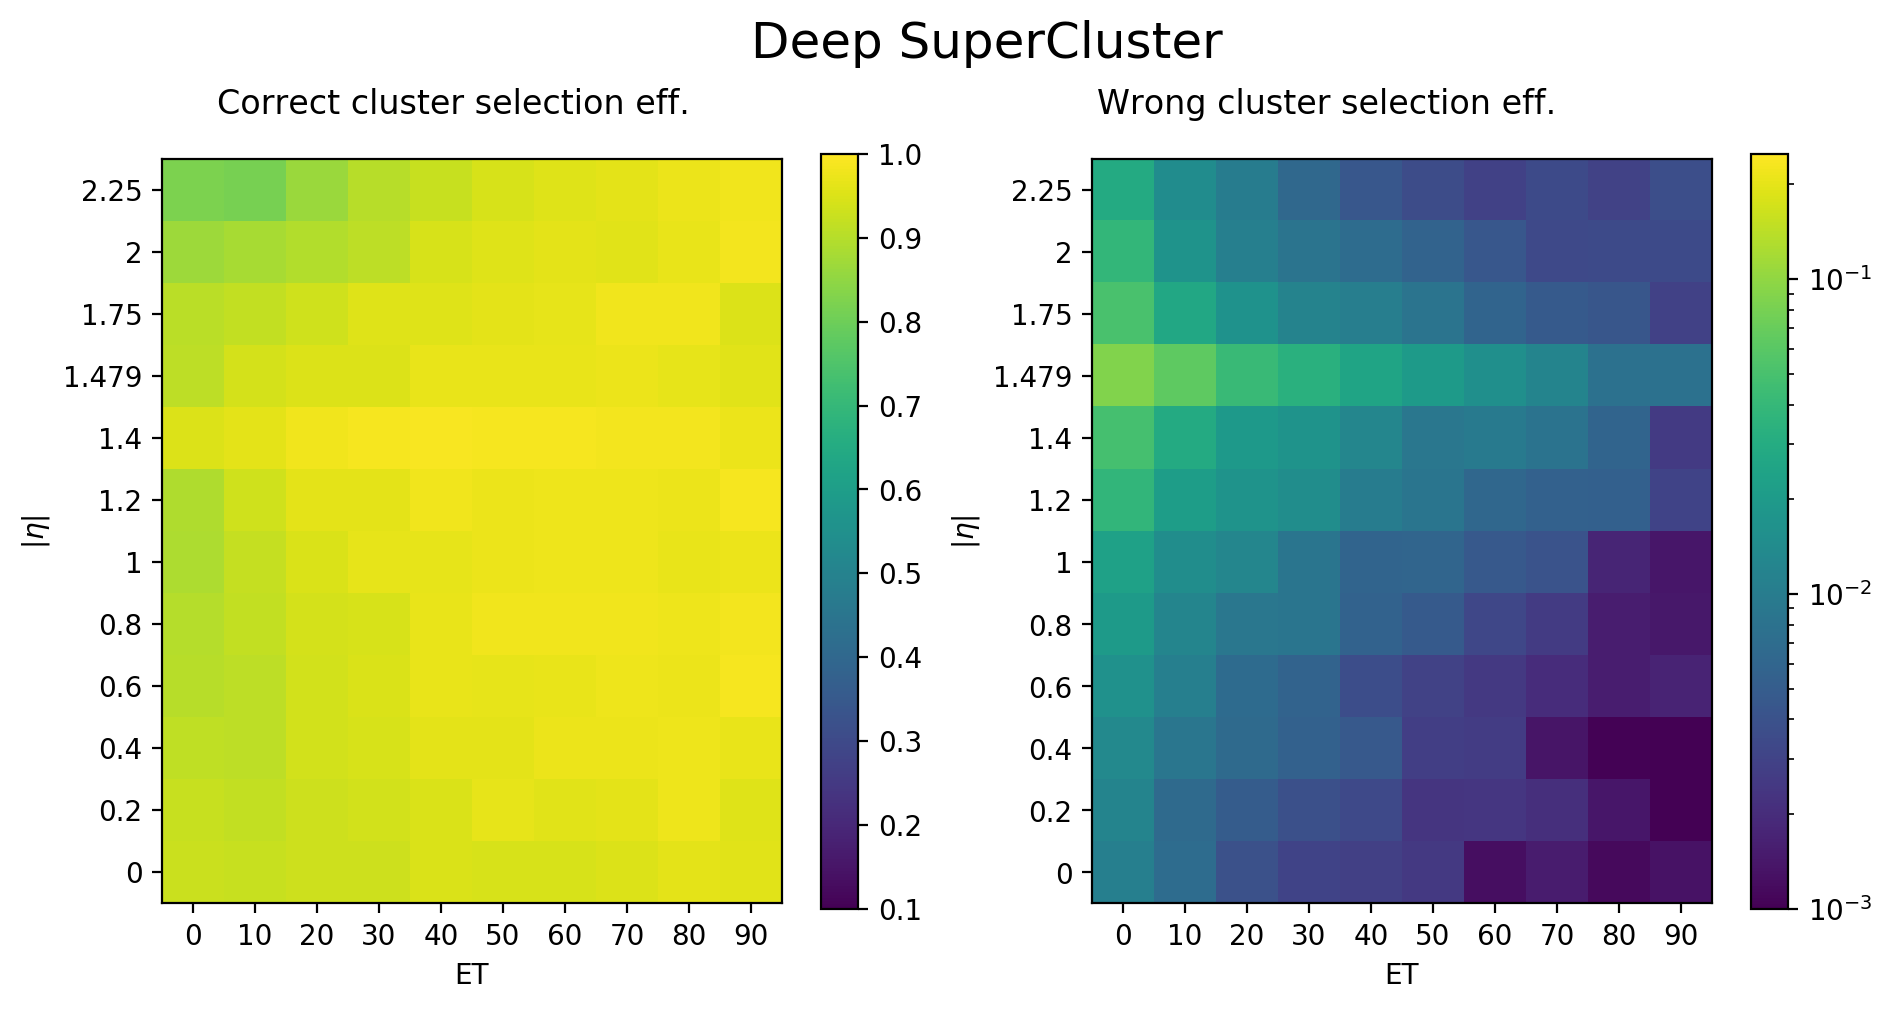

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(11,5), dpi=200)
im = ax1.imshow(results[:,:,0], vmax=1, vmin=0.1)
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1)

im2 = ax2.imshow(results[:,:,1], norm=colors.LogNorm(), vmax=2.5e-1, vmin=1e-3)
ax2.set_xticks(np.arange(len(ens)-1))
ax2.set_yticks(np.arange(len(etas)-1))
ax2.set_yticklabels(etas)
ax2.set_xticklabels(ens)
ax2.set_xlabel("ET")
ax2.set_ylabel("$|\eta|$")
fig.colorbar(im2, ax=ax2)


fig.text(0.5, 0.99, "Deep SuperCluster", ha="center", va="center", fontsize=18)
fig.text(0.15, 0.92, "Correct cluster selection eff.", fontsize=12)
fig.text(0.55, 0.92, "Wrong cluster selection eff.", fontsize=12)

plot


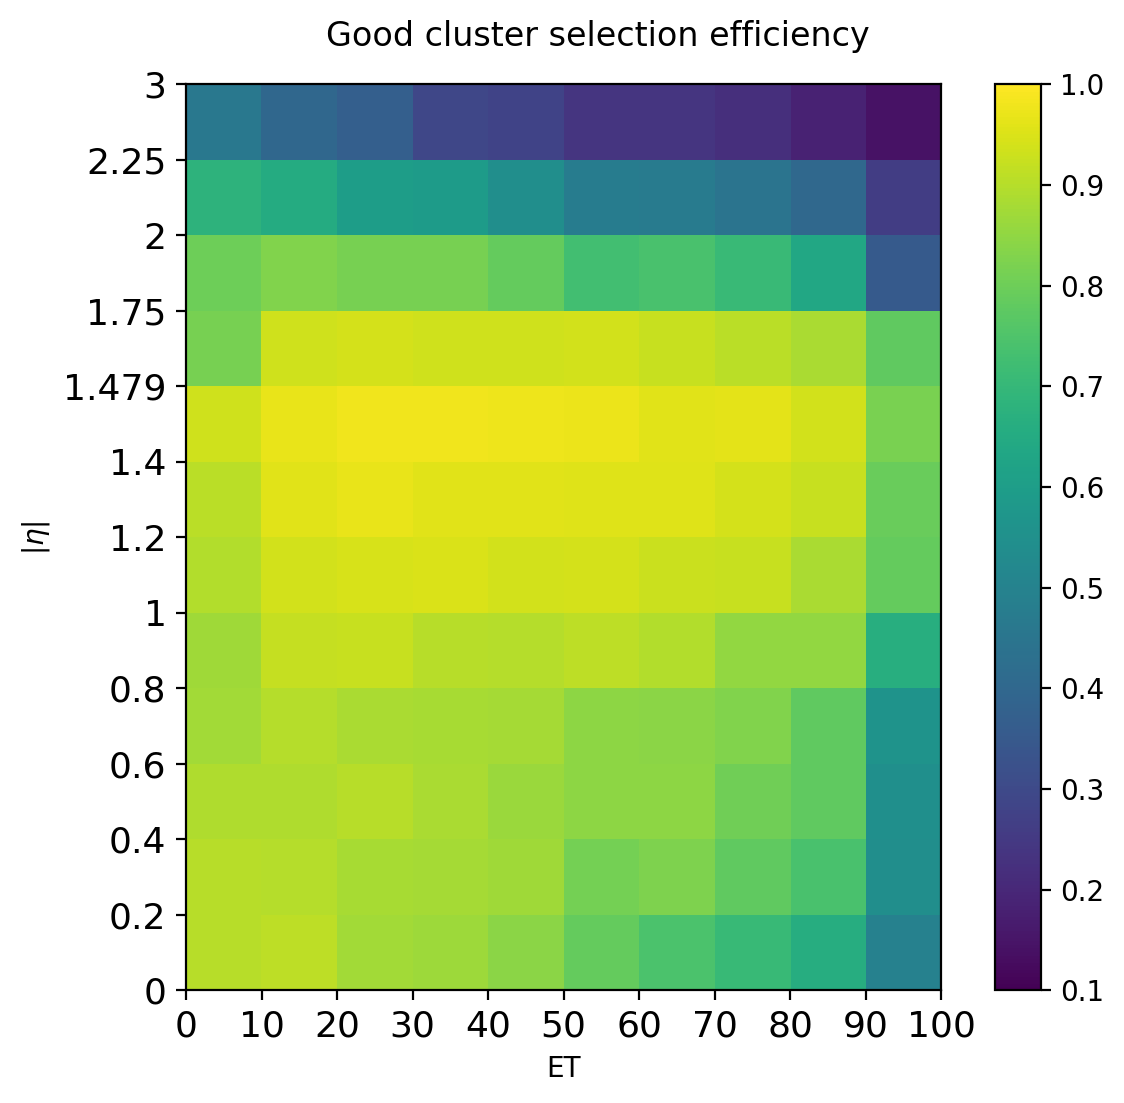

In [44]:
fig,ax1 = plt.subplots(figsize=(7,6), dpi=200)
im = ax1.imshow(results[:,:,0], vmax=1, vmin=0.1)
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1)

locs, labels= plt.xticks()
labels.append("100")
locs = np.append(locs, [10])
plt.xticks(locs-0.5, labels)

locs, labels= plt.yticks()
labels.append("3")
locs = np.append(locs, locs[-1]+1)
plt.yticks(locs-0.5, labels)

fig.text(0.5, 0.92, "Good cluster selection efficiency", fontsize=12, va="center", ha="center")

plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
print("plot")

([<matplotlib.axis.YTick at 0x7f2cef61d588>,
 <a list of 13 Text yticklabel objects>)

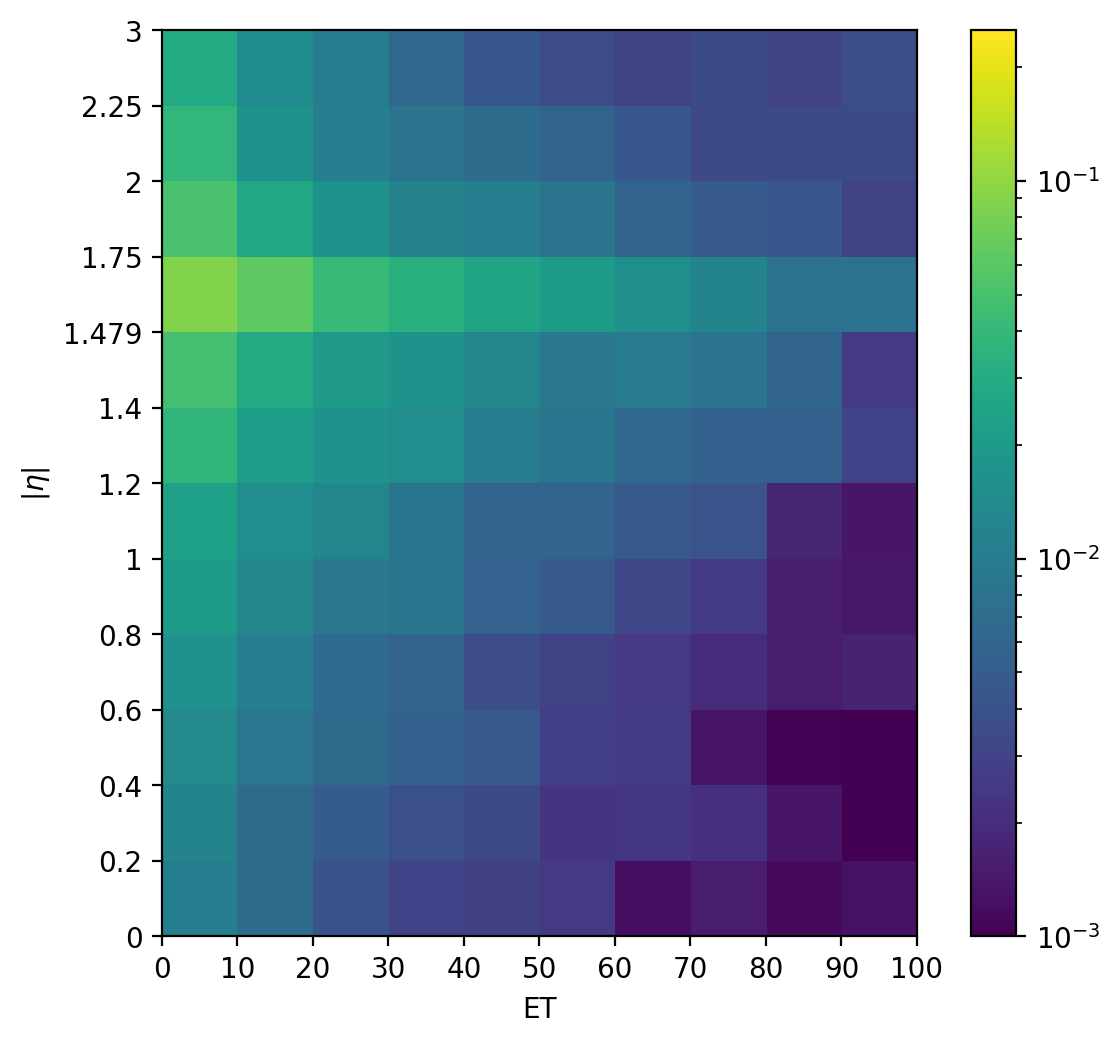

In [50]:
fig,ax1 = plt.subplots(figsize=(7,6), dpi=200)
im = ax1.imshow(results[:,:,1], norm=colors.LogNorm(), vmax=2.5e-1 , vmin=1e-3)
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1)

locs, labels= plt.xticks()
labels.append("100")
locs = np.append(locs, [10])
plt.xticks(locs-0.5, labels)

locs, labels= plt.yticks()
labels.append("3")
locs = np.append(locs, locs[-1]+1)
plt.yticks(locs-0.5, labels)


### Signal and background eff mustache

In [ ]:
etas = [0, 0.2, 0.4 ,0.6, 0.8, 1, 1.2, 1.4, 1.479, 1.75, 2, 2.25, 3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#etas = [0, 1, 2]
#ens= [0, 50, 100]

results = np.zeros((len(etas)-1, len(ens)-1, 2))


for ieta in range(len(etas)-1):
    for ien in range(len(ens)-1):
        eta_min = etas[ieta]
        eta_max = etas[ieta+1]
        et_min = ens[ien]
        et_max = ens[ien+1]
        print(eta_min, eta_max, et_min, et_max)
        
        data_out_tot = F_must[(abs(F_must.seed_eta) > eta_min) & (abs(F_must.seed_eta) < eta_max) &
                            (F_must.en_seed / np.cosh(F_must.seed_eta)  > et_min) & (F_must.en_seed / np.cosh(F_must.seed_eta) < et_max) ].size
        data_out_1 = FP_must[(abs(FP_must.seed_eta) > eta_min) & (abs(FP_must.seed_eta) < eta_max) &
                            (FP_must.en_seed / np.cosh(FP_must.seed_eta)  > et_min) & (FP_must.en_seed / np.cosh(FP_must.seed_eta) < et_max) ].size
        data_in_tot = T_must[ (abs(T_must.seed_eta) > eta_min) & (abs(T_must.seed_eta) < eta_max) &
                            (T_must.en_seed / np.cosh(T_must.seed_eta)  > et_min) & (T_must.en_seed / np.cosh(T_must.seed_eta) < et_max) ].size
        data_in_1 = TP_must[(abs(TP_must.seed_eta) > eta_min) & (abs(TP_must.seed_eta) < eta_max) &
                            (TP_must.en_seed / np.cosh(TP_must.seed_eta)  > et_min) & (TP_must.en_seed / np.cosh(TP_must.seed_eta) < et_max) ].size
        
        results[ieta, ien, :] = np.array([data_in_1 / data_in_tot , data_out_1 / data_out_tot])

0 0.2 0 10
0 0.2 10 20
0 0.2 20 30
0 0.2 30 40
0 0.2 40 50
0 0.2 50 60
0 0.2 60 70
0 0.2 70 80
0 0.2 80 90
0 0.2 90 100
0.2 0.4 0 10
0.2 0.4 10 20
0.2 0.4 20 30
0.2 0.4 30 40
0.2 0.4 40 50
0.2 0.4 50 60
0.2 0.4 60 70
0.2 0.4 70 80
0.2 0.4 80 90
0.2 0.4 90 100
0.4 0.6 0 10
0.4 0.6 10 20
0.4 0.6 20 30
0.4 0.6 30 40
0.4 0.6 40 50
0.4 0.6 50 60
0.4 0.6 60 70
0.4 0.6 70 80
0.4 0.6 80 90
0.4 0.6 90 100
0.6 0.8 0 10
0.6 0.8 10 20
0.6 0.8 20 30
0.6 0.8 30 40
0.6 0.8 40 50
0.6 0.8 50 60
0.6 0.8 60 70
0.6 0.8 70 80
0.6 0.8 80 90
0.6 0.8 90 100
0.8 1 0 10
0.8 1 10 20
0.8 1 20 30
0.8 1 30 40
0.8 1 40 50
0.8 1 50 60
0.8 1 60 70
0.8 1 70 80
0.8 1 80 90
0.8 1 90 100
1 1.2 0 10
1 1.2 10 20
1 1.2 20 30
1 1.2 30 40
1 1.2 40 50
1 1.2 50 60
1 1.2 60 70
1 1.2 70 80
1 1.2 80 90
1 1.2 90 100
1.2 1.4 0 10
1.2 1.4 10 20


Text(0.55, 0.92, 'Wrong cluster selection eff.')

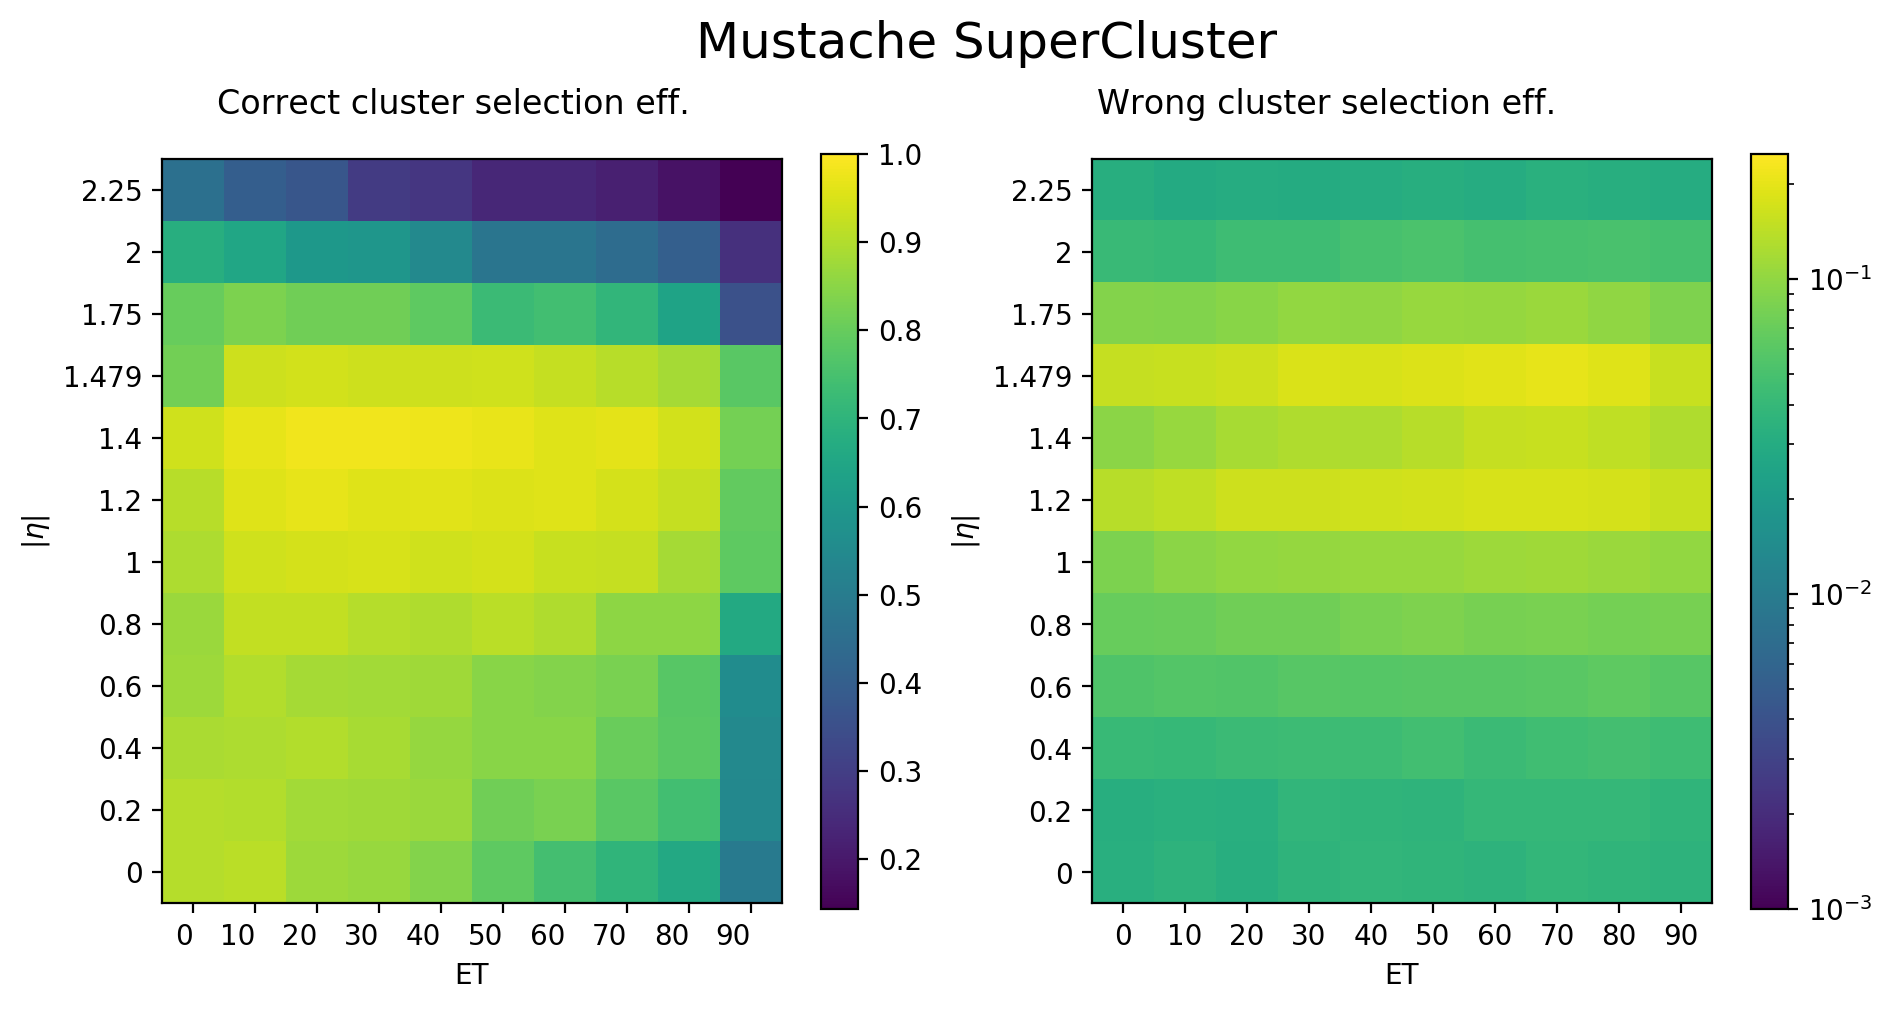

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(11,5), dpi=200)
im = ax1.imshow(results[:,:,0], vmax=1)
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1)

im2 = ax2.imshow(results[:,:,1], norm=colors.LogNorm(), vmax=2.5e-1, vmin=1e-3)
ax2.set_xticks(np.arange(len(ens)-1))
ax2.set_yticks(np.arange(len(etas)-1))
ax2.set_yticklabels(etas)
ax2.set_xticklabels(ens)
ax2.set_xlabel("ET")
ax2.set_ylabel("$|\eta|$")
fig.colorbar(im2, ax=ax2)

plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')


fig.text(0.5, 0.99, "Mustache SuperCluster", ha="center", va="center", fontsize=18)
fig.text(0.15, 0.92, "Correct cluster selection eff.", fontsize=12)
fig.text(0.55, 0.92, "Wrong cluster selection eff.", fontsize=12)

# Energy contamination plots
## Energy outside of mustache

Plot of lost clusters

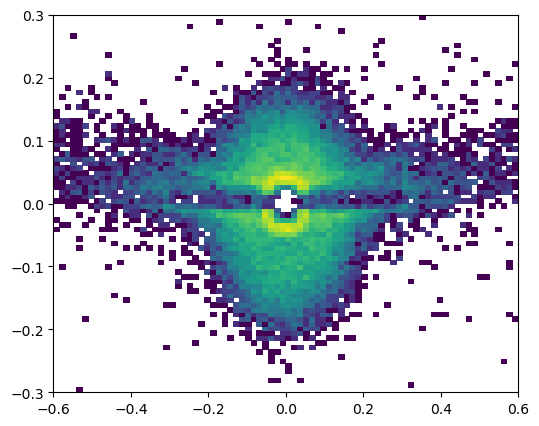

In [10]:
fig,ax2 = plt.subplots(figsize=(6,5), dpi=100)
_ = ax2.hist2d(FN_must.cluster_dphi, FN_must.cluster_deta,   
            bins=(80,80), range=((-0.6, 0.6),(-0.3, 0.3)), cmap="viridis", norm=colors.LogNorm())

## Check fraction of energy outside of supercluster

### Mustache

In [12]:
# False negative or lost energy
g_FN_must = FN_must[FN_must.is_seed==False].groupby("window_index", sort=False).agg(
    {"en_cluster": "sum", 
     "en_true":"first", 
     "en_seed": "first",
     "seed_eta": "first",
     "seed_phi": "first"})

g_FN_must["lost_fraction"] = g_FN_must["en_cluster"] / g_FN_must["en_true"]

# False positive or contamination
g_FP_must = FP_must[FP_must.is_seed==False].groupby("window_index", sort=False).agg(
    {"en_cluster": "sum", 
     "en_true":"first", 
     "en_seed": "first",
     "seed_eta": "first",
     "seed_phi": "first"})

g_FP_must["lost_fraction"] = g_FP_must["en_cluster"] / g_FP_must["en_true"]

#### DNN 

g_FN_dnn = data_in[(data_in.is_seed==False) & (data_in.y_shower < 0.88)].groupby("window_index", sort=False).agg(
    {"en_cluster": "sum", 
     "en_true":"first", 
     "en_seed": "first",
     "seed_eta": "first",
     "seed_phi": "first"})

g_FN_dnn["lost_fraction"] = g_FN_dnn["en_cluster"] / g_FN_dnn["en_true"]

g_FP_dnn = data_out[(data_out.is_seed==False) & (data_out.y_shower > 0.88)].groupby("window_index", sort=False).agg(
    {"en_cluster": "sum", 
     "en_true":"first", 
     "en_seed": "first",
     "seed_eta": "first",
     "seed_phi": "first"})

g_FP_dnn["lost_fraction"] = g_FP_dnn["en_cluster"] / g_FP_dnn["en_true"]

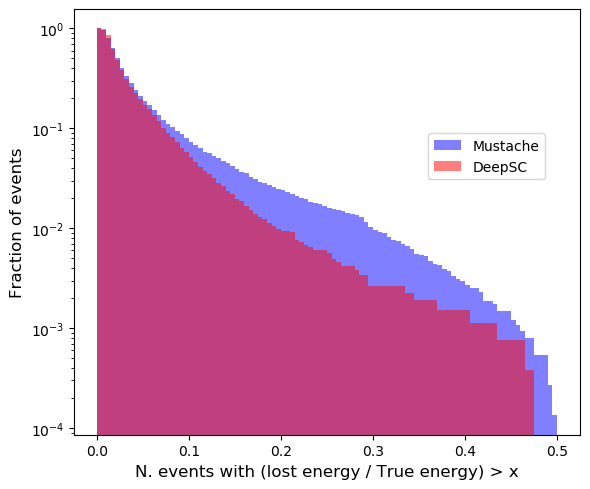

In [57]:
fig, ax1 = plt.subplots(figsize=(6,5), dpi=100)
ax1.hist(g_FN_must.lost_fraction, density=True, cumulative=-1, range=(0,0.5), bins=100, color="b", alpha=0.5, label="Mustache")
ax1.hist(g_FN_dnn.lost_fraction, density=True, cumulative=-1, range=(0,0.5), bins=100, color="r", alpha=0.5, label="DeepSC")
ax1.set_xlabel("Fraction of events with (lost energy / True energy) > x",fontsize=12)
ax1.set_ylabel("Fraction of events", fontsize=12)
ax1.set_yscale("log")
ax1.legend(loc=(0.7, 0.6))
fig.tight_layout()

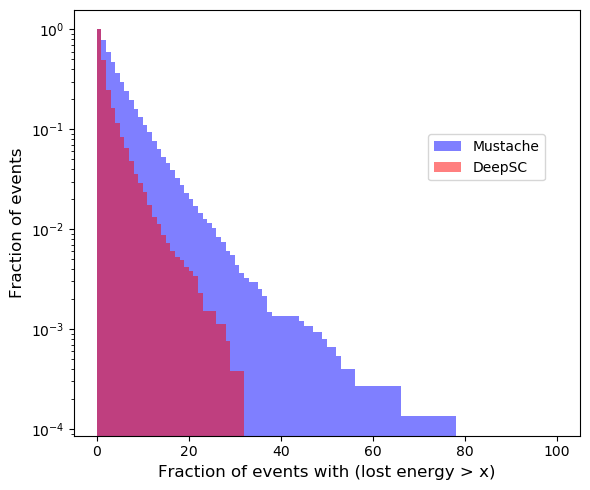

In [59]:
fig, ax1 = plt.subplots(figsize=(6,5), dpi=100)
ax1.hist(g_FN_must.en_cluster, density=True, cumulative=-1, range=(0,100), bins=100, color="b", alpha=0.5, label="Mustache")
ax1.hist(g_FN_dnn.en_cluster, density=True, cumulative=-1, range=(0,100), bins=100, color="r", alpha=0.5, label="DeepSC")
ax1.set_title("Fraction of events with (lost energy > x)",fontsize=18)
ax1.set_xlabel("Lost energy (GeV)")
ax1.set_ylabel("Fraction of events", fontsize=12)
ax1.set_yscale("log")
ax1.legend(loc=(0.7, 0.6))
fig.tight_layout()

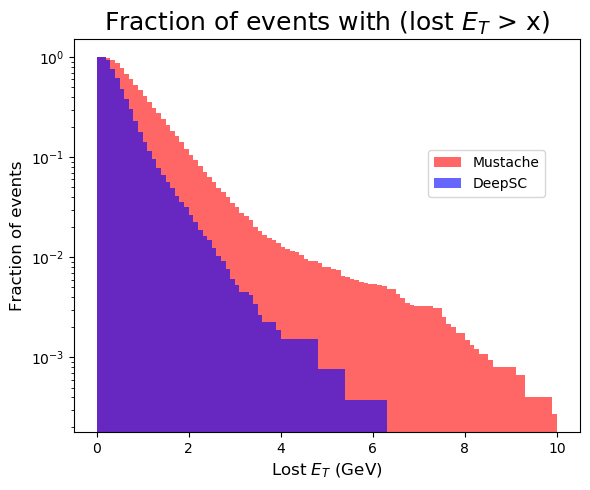

In [69]:
fig, ax1 = plt.subplots(figsize=(6,5), dpi=100)
ax1.hist(g_FN_must.en_cluster / np.cosh(g_FN_must.seed_eta), density=True, cumulative=-1, range=(0,10), bins=100, color="r", alpha=0.6, label="Mustache")
ax1.hist(g_FN_dnn.en_cluster / np.cosh(g_FN_dnn.seed_eta), density=True, cumulative=-1, range=(0,10), bins=100, color="b", alpha=0.6, label="DeepSC")
ax1.set_title("Fraction of events with (lost $E_T$ > x)",fontsize=18)
ax1.set_xlabel("Lost $E_T$ (GeV)", fontsize=12)
ax1.set_ylabel("Fraction of events", fontsize=12)
ax1.set_yscale("log")
ax1.legend(loc=(0.7, 0.6))
fig.tight_layout()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,5), dpi=100)
ax1.hist(g_FN_must.en_cluster / np.cosh(g_FN_must.seed_eta), density=True, cumulative=-1, range=(0,10), bins=100, color="b", alpha=0.5, label="Mustache")
ax1.hist(g_FN_dnn.en_cluster / np.cosh(g_FN_dnn.seed_eta), density=True, cumulative=-1, range=(0,10), bins=100, color="r", alpha=0.5, label="DeepSC")
ax1.set_xlabel("Fraction of events with (lost $E_T$ > x)",fontsize=12)
ax1.set_ylabel("Fraction of events", fontsize=12)
ax1.set_yscale("log")
ax1.legend(loc=(0.7, 0.6))
fig.tight_layout()

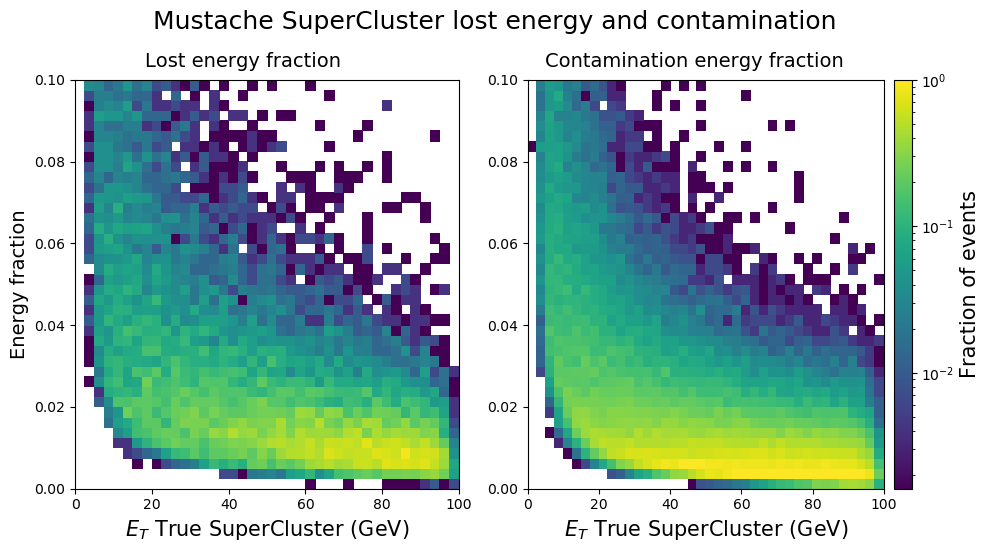

In [29]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)

h1_, *_, h1 = ax1.hist2d(g_FN_must.en_true / np.cosh(g_FN_must.seed_eta),g_FN_must.lost_fraction,  range=((0,100),(0,0.1)),  
                             bins=(40,40), norm=colors.LogNorm(), density=True, vmax=1)
ax1.set_ylabel("Energy fraction", fontsize=14)
ax1.set_xlabel("$E_T$ True SuperCluster (GeV)", fontsize=15)

h2_, *_, h2 = ax2.hist2d(g_FP_must.en_true / np.cosh(g_FP_must.seed_eta), g_FP_must.lost_fraction, range=((0,100),(0,0.1)), 
                         bins=(40,40), norm=colors.LogNorm(), density=True,  vmax=1)
#ax2.set_ylabel("Contamination energy fraction",fontsize=14)
ax2.set_xlabel("$E_T$ True SuperCluster (GeV)",fontsize=15)


divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
cb = fig.colorbar(h2, cax=cax2 )
cb.set_label("Fraction of events", fontsize=15)

fig.text(0.5, 1.07, "Mustache SuperCluster lost energy and contamination", ha="center", va="center", fontsize=18)
fig.text(0.15, 0.98, "Lost energy fraction", fontsize=14 )
fig.text(0.55, 0.98, "Contamination energy fraction", fontsize=14 )

#plt.subplots_adjust(wspace = -.015, hspace=0.25)

fig.tight_layout()

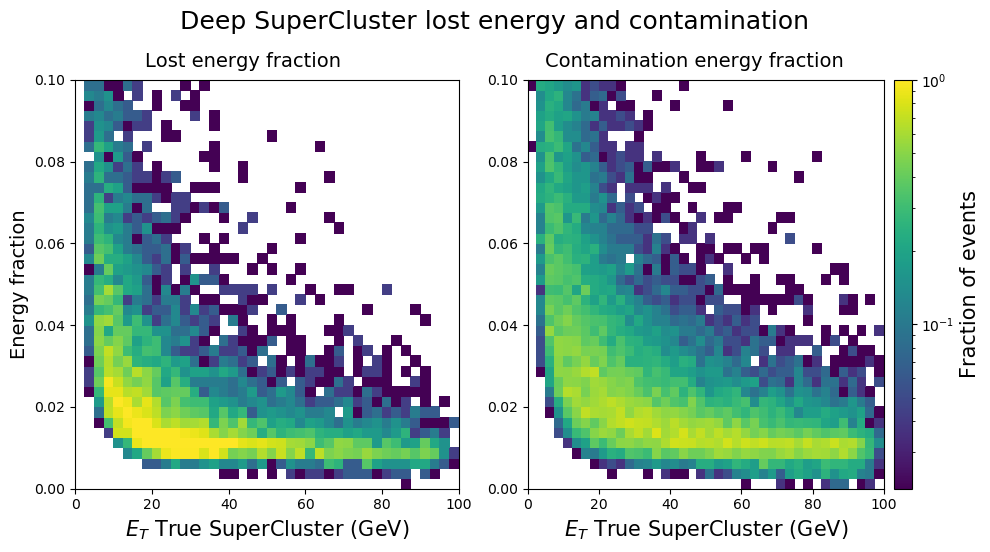

In [32]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)


h1_, *_, h1 = ax1.hist2d(g_FN_dnn.en_true / np.cosh(g_FN_dnn.seed_eta), g_FN_dnn.lost_fraction, range=((0,100),(0,0.1)),  
                             density=True, bins=(40,40), norm=colors.LogNorm(), vmax=1)
ax1.set_ylabel("Energy fraction", fontsize=14)
ax1.set_xlabel("$E_T$ True SuperCluster (GeV)", fontsize=15)


h2_, *_, h2 = ax2.hist2d( g_FP_dnn.en_true / np.cosh(g_FP_dnn.seed_eta), g_FP_dnn.lost_fraction, range=((0,100),(0,0.1)),  
                         density = True, bins=(40,40), norm=colors.LogNorm(), vmax=1)
#ax2.set_ylabel("Contamination energy fraction",fontsize=14)
ax2.set_xlabel("$E_T$ True SuperCluster (GeV)",fontsize=15)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
cb = fig.colorbar(h1, cax=cax2 )
cb.set_label("Fraction of events", fontsize=15)

fig.text(0.5, 1.07, "Deep SuperCluster lost energy and contamination", ha="center", va="center", fontsize=18)
fig.text(0.15, 0.98, "Lost energy fraction", fontsize=14 )
fig.text(0.55, 0.98, "Contamination energy fraction", fontsize=14 )

fig.tight_layout()